# Welcome to the notebook that trains the model to extract rod positions and angles

Welcome to foosbot

In [2]:
#!pip install keras
#!pip install numpy
#!pip install imageio
#!pip install matplotlib
#!pip install opencv-python
#C:\Program Files\NVIDIA Corporation\NVSMI\nvidia-smi.exe dmon -s u

In [1]:
from __future__ import print_function


from video_file import *

import importlib
try:
    importlib.reload(video_file)
except:
    pass

import cv2
import sys
import os
import csv
import numpy as np
from random import randint
from random import shuffle

from PIL import Image
import imageio
import itertools as it

import tensorflow as tf
import keras
print("Keras version %s" % keras.__version__)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K

print("Tensorflow version %s" % tf.__version__)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

import pprint
pp = pprint.PrettyPrinter(depth=6)


# Create the image transformer
transformer = VideoTransform( zoom_range=0.05, rotation_range=3, width_shift_range=0.05,
                             height_shift_range=0.05, shear_range= 0.05, fill_mode='constant',
                             color_rescale_range=0.3, color_offset_range=0.3, brightness_rescale_range=0.3,
                             brightness_offset_range=0.3, white_noise=0.05, gaussian_noise=0.1, 
                             vertical_flip=False, horizontal_flip=True, horizontal_flip_invert_indices = [],
                             horizontal_flip_reverse_indices = [0], data_format='channels_last',
                             random_crop=(70,320), resize=(35,160) )


# Paths relative to current python file.
data_path  = ".\\..\\..\\TrainingData\\Processed\\RodTrainingData\\Result\\settings.tsv"

Using TensorFlow backend.


Keras version 2.0.8
Tensorflow version 1.3.0


In [2]:
print("Opening training frames from config %s." % (data_path))

position_rel_indexes = [0]
frame_rel_indexes = [0]

training = TrainingInput(transformer, data_path, position_rel_indexes, frame_rel_indexes, 0.2, keep_in_memory=True)


Opening training frames from config .\..\..\TrainingData\Processed\RodTrainingData\Result\settings.tsv.
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingData\Result\chunk0.avi
.\..\..\TrainingData\Processed\RodTrainingData\Result\chunk0.avi
(35, 160, 3)
Loading normalized frames into memory...
added 3054 new frames for a total of 3054
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingData\Result\chunk1.avi
.\..\..\TrainingData\Processed\RodTrainingData\Result\chunk1.avi
(35, 160, 3)
Loading normalized frames into memory...
added 4401 new frames for a total of 7455
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingData\Result\chunk2.avi
.\..\..\TrainingData\Processed\RodTrainingData\Result\chunk2.avi
(35, 160, 3)
Loading normalized frames into memory...
added 4500 new frames for a total of 11955
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingData\Result\chunk3.avi
.\..\..\TrainingData\Processed\RodTr

In [11]:
# https://stanford.edu/~shervine/blog/keras-generator-multiprocessing.html
class threadsafe_iter(object):
  """
    Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
  def __init__(self, it):
      self.it = it
      self.lock = threading.Lock()

  def __iter__(self):
      return self

  def __next__(self):
      with self.lock:
          return self.it.__next__()

# https://stanford.edu/~shervine/blog/keras-generator-multiprocessing.html
def threadsafe_generator(f):
  """
    A decorator that takes a generator function and makes it thread-safe.
    """
  def g(*a, **kw):
      return threadsafe_iter(f(*a, **kw))
  return g



# Define our training and validation iterators
@threadsafe_generator
def TrainGen(model, training):
    while True:
        #print("TrainGen restarting training input.")
        model.reset_states()
        training.move_first_training_frame()
        (frames, output, reset_memory) = training.get_next_training_frame()
        while frames is not None:
            yield (frames, output)
            (frames, output, reset_memory) = training.get_next_training_frame()
            
            if reset_memory or frames is None:
                model.reset_states()
                
@threadsafe_generator
def ValidateGen(model, training):
    while True:
        #print("Validation restarting training input.")
        model.reset_states()
        training.move_first_validation_frame()
        (frames, output, reset_memory) = training.get_next_validation_frame()
        while frames is not None:
            yield (frames, output)
            (frames, output, reset_memory) = training.get_next_validation_frame()
            
            if reset_memory or frames is None:
                model.reset_states()

# Generators for training the position
@threadsafe_generator
def TrainBatchGen(batch_size, model, training):
    gen = TrainGen(model, training)
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, training.depth, training.height, training.width, training.channels), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 1), dtype=np.float32)
        for i in range(batch_size):
            (frames, output) = next(gen)
            batch_frames[i,:,:,:,:] = frames
            batch_outputs[i,:] = output[0] # Teach it to control the 2-bar
            #batch_outputs[i,:] = output[3:6] - output[0:3] # Train the difference in the three rod positions as output
            #batch_outputs[i,:] = output
            
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")

@threadsafe_generator
def ValidateBatchGen(batch_size, model, training):
    gen = ValidateGen(model, training)
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, training.depth, training.height, training.width, training.channels), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 1), dtype=np.float32)
        for i in range(batch_size):
            (frames, output) = next(gen)
            batch_frames[i,:,:,:,:] = frames
            batch_outputs[i,:] = output[0] # Teach it to control the 2-bar
            #batch_outputs[i,:] = output[3:6] - output[0:3] # Train the difference in the three rod positions as output
            #batch_outputs[i,:] = output
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")
        
# Generators for training the position
@threadsafe_generator
def TrainBatchGen2(batch_size, model, training):
    gen = TrainGen(model, training)
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, training.depth, training.height, training.width, training.channels), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 1), dtype=np.float32)
        for i in range(batch_size):
            (frames, output) = next(gen)
            batch_frames[i,:,:,:,:] = frames
            batch_outputs[i,:] = output[0] # Teach it to control the 2-bar
            #batch_outputs[i,:] = output[3:6] - output[0:3] # Train the difference in the three rod positions as output
            #batch_outputs[i,:] = output
            
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")

@threadsafe_generator
def ValidateBatchGen2(batch_size, model, training):
    gen = ValidateGen(model, training)
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, training.depth, training.height, training.width, training.channels), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 1), dtype=np.float32)
        for i in range(batch_size):
            (frames, output) = next(gen)
            batch_frames[i,:,:,:,:] = frames
            batch_outputs[i,:] = output[0] # Teach it to control the 2-bar
            #batch_outputs[i,:] = output[3:6] - output[0:3] # Train the difference in the three rod positions as output
            #batch_outputs[i,:] = output
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")
    
# Helper function to plot our validation result
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import pandas as pd
%matplotlib inline


def plot_validate(generator, model, count, name):
    #plot_validate(ValidateBatchGen(batch_size, model), model, 2000, "Position prediction")
    
    outputs_predicted = None
    outputs_true = None
    
    while outputs_predicted is None or outputs_predicted.shape[0] < count:
        
        (new_frames, new_outputs_true) = next(generator)
        if outputs_true is None:
            outputs_true = new_outputs_true
        else:
            outputs_true = np.concatenate( (outputs_true, new_outputs_true), axis=0 )
        
        
        new_outputs_predicted = model.predict(new_frames, batch_size=new_frames.shape[0], verbose=0)
        if outputs_predicted is None:
            outputs_predicted = new_outputs_predicted
        else:
            outputs_predicted = np.concatenate( (outputs_predicted, new_outputs_predicted), axis=0 )
    
    #(frames, outputs_true) = next(ValidateBatchGen(2000))
    #frames = np.squeeze(frames, axis=(1,))
    #validate_in, validate_out
    #frames = validate_in
    #outputs_true =validate_out
    
    outputs_predicted = np.clip(outputs_predicted,0.0,1.0)
    print("Predicted.")
    
    
    #pp.pprint(outputs_true)
    #pp.pprint(outputs_predicted)
    
    
    #plt.figure(figsize=(8,30))
    plt.figure()
    
    #plt.subplot(111)
    p1, = plt.plot(range(count),outputs_true[0:count,0], label="True position")
    p2, = plt.plot(range(count),outputs_predicted[0:count,0], label = "Predicted position")
    plt.ylabel("%s" % name)
    plt.title("True and predicted rod positions")
    plt.grid(True)
    plt.legend()
    
    
    
    #plt.figure(figsize=(8,30))
    #plt.subplot(111)
    plt.figure()
    
    true, predicted = zip(*sorted(zip(outputs_true[0:count,0], outputs_predicted[0:count,0])))
    p1, = plt.plot(range(count),true, label="True position" )
    p2, = plt.plot(range(count),predicted, label="Predicted position" )
    plt.ylabel("%s" % name)
    plt.title("Sorted true and predicted rod positions")
    plt.grid(True)
    plt.legend()
    #legend = ax.legend(loc='upper center', shadow=True)
    
    
    plt.show()
          
def mse(y_true, y_pred):
    return K.square(keras.backend.clip(y_pred,0.0,1.0) - keras.backend.clip(y_true,0.0,1.0))*0.001 # Hackjob so Keras iterations show exponential value of MSE to get precision.

def me(y_true, y_pred):
    return keras.backend.clip(K.abs(keras.backend.clip(y_pred,0.0,1.0) - keras.backend.clip(y_true,0.0,1.0)),0.0,0.2)*0.001 # Hackjob so Keras iterations show exponential value of MSE to get precision.

def run_train(model, batch_size, training, lr, start_epoch, num_epochs, WEIGHTS_FNAME, MODELS_FNAME, plot_frequency):
    model.compile(optimizer=keras.optimizers.RMSprop(lr=lr),
                  loss=me,
                  metrics=[me, mse])
    batches_training_per_epoch = int(training.get_training_count() / batch_size)
    batches_validation_per_epoch = int(training.get_validation_count() / batch_size)
    
    print("Starting at lr=%f" % lr)
    print("Batch size %i: %i training batches, %i validation batches" % (batch_size, batches_training_per_epoch, batches_validation_per_epoch) )
    stop = False
    model.reset_states()
    for epoch in range(start_epoch, start_epoch + num_epochs):
        try:
            training.move_first_validation_frame()
            model.fit_generator(TrainBatchGen(batch_size, model, training), batches_training_per_epoch, epochs=epoch+1, verbose=1, callbacks=None, class_weight=None, max_q_size=50, workers=50, validation_data=ValidateBatchGen(batch_size, model, training), validation_steps = batches_validation_per_epoch, initial_epoch=epoch)
            training.move_first_validation_frame()
            model.save_weights(WEIGHTS_FNAME % epoch)
            model.save(MODELS_FNAME % epoch)
            if epoch % plot_frequency == 0:
                plot_validate(ValidateBatchGen(batch_size, model, training), model, 2000, "Position prediction")
            print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)
        except KeyboardInterrupt:
            print("\r\nUser stopped the training.")
            stop = True
            break

    return (epoch+1, stop)

def run_train2(model, batch_size, training, lr, start_epoch, num_epochs, WEIGHTS_FNAME, MODELS_FNAME, plot_frequency):
    model.compile(optimizer=keras.optimizers.RMSprop(lr=lr),
                  loss='mean_squared_error',
                  metrics=[mse])
    batches_training_per_epoch = int(training.get_training_count() / batch_size)
    batches_validation_per_epoch = int(training.get_validation_count() / batch_size)
    
    print("Starting at lr=%f" % lr)
    print("Batch size %i: %i training batches, %i validation batches" % (batch_size, batches_training_per_epoch, batches_validation_per_epoch) )
    stop = False
    model.reset_states()
    for epoch in range(start_epoch, start_epoch + num_epochs):
        try:
            model.fit_generator(TrainBatchGen2(batch_size, model, training), batches_training_per_epoch, epochs=epoch+1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=10, validation_data=ValidateBatchGen2(batch_size, model, training), validation_steps = batches_validation_per_epoch, pickle_safe=False, initial_epoch=epoch)
            model.save_weights(WEIGHTS_FNAME % epoch)
            model.save(MODELS_FNAME % epoch)
            if epoch % plot_frequency == 0:
                plot_validate(ValidateBatchGen2(batch_size, model, training), model, 2000, "Position prediction")
            print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)
        except KeyboardInterrupt:
            print("\r\nUser stopped the training.")
            stop = True
            break

    return (epoch+1, stop)

# Input training frame

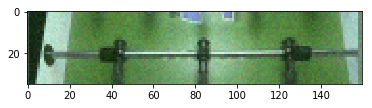

[0.5]


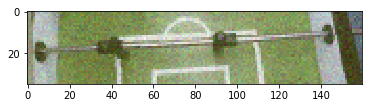

[0.2076271186440678]


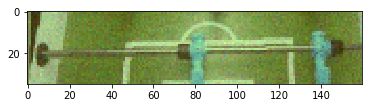

[0.7751479289940828]


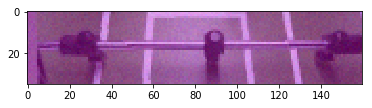

[0.6227272727272727]


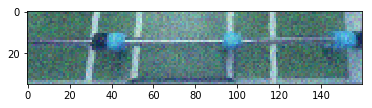

[0.9675675675675676]


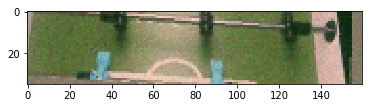

[0.7881773399014779]


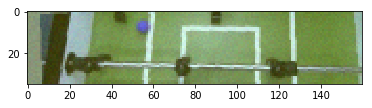

[0.07272727272727275]


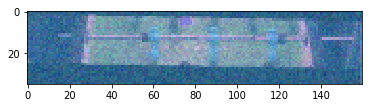

[0.7338129496402878]


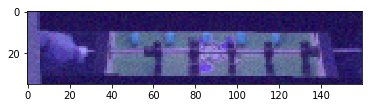

[0.9848484848484849]


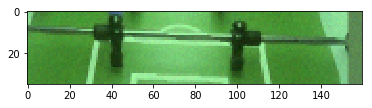

[0.47790055248618785]
Shape of training input:
(1, 35, 160, 3)
Shape of training output:
(1,)
Corresponding Positions:
[0.47790055248618785]


In [8]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import pandas as pd
%matplotlib inline

#training.move_first_training_frame()

for k in range(10):
    (frame, position, reset) = training.get_next_training_frame()
    
    data = np.zeros(shape=(np.shape(frame)[1], np.shape(frame)[2] * np.shape(frame)[0], 3), dtype=np.float32)
    for i in range(np.shape(frame)[0]):
        tmp = frame[i,:,:,:]
        tmp = tmp - np.min(tmp)
        tmp = tmp / np.max(tmp)
        data[:,i*np.shape(frame)[2]:(i+1)*np.shape(frame)[2],:] = tmp


    plt.imshow(data, 'gray')
    plt.show()
    pp.pprint(position)

#training.move_first_training_frame()

print("Shape of training input:")
pp.pprint(np.shape(frame))

print("Shape of training output:")
pp.pprint(np.shape(position))

print("Corresponding Positions:")
pd.DataFrame(position)
pp.pprint(position)




# Specify the model structure we will use

In [9]:
from keras.models import Sequential
from keras.layers import *
from keras.models import Model


number_of_frames = 1
image_height       = training.height
image_width        = training.width
image_depth        = training.depth
image_channels     = training.channels
output_size        = 1

# Model options
batch_size = 10
cnn_kernel_count = 100

# Build the model
pp.pprint("Input shape without batches:")
pp.pprint((image_depth, image_height, image_width, image_channels))

# Used to give fixed names to the layers for transferring the model
conv_num = 0 
pool_num = 0
dense_num = 0

 # (?, 1, 90, 320, cnn_kernel_count, 3 )
# Build a functional model design
inputs = Input(shape=(number_of_frames, image_height, image_width, image_channels,),
              name="Input")
x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(inputs)
conv_num+=1

x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1

# Split into a horizontal detail and vertical detailed CNN paths
x = MaxPooling3D( pool_size=(1, 1, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 45, 150, cnn_kernel_count, 3 )
pool_num+=1

x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1

x = MaxPooling3D( pool_size=(1, 1, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 45, 75, 128, 3 )
pool_num+=1

x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling3D( pool_size=(1, 2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x)
pool_num+=1

x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling3D( pool_size=(1, 2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x)
pool_num+=1



x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling3D( pool_size=(1, 2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x)
pool_num+=1

x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1


x = Flatten()(x)
x = Dropout(0.5)(x)


x = Dense(64, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)
predictions = Dense(1, activation='linear',name="dense_%i"%dense_num)(x)
dense_num+=1


model = Model(inputs=inputs, outputs=predictions)


# For a multi-class classification problem
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])


model.summary()

# Train the model to predict the future position. This is the control signal to the robot AI
WEIGHTS_FNAME = '.\\RodPosition\\pos_cnn_weights_%i.hdf'
MODELS_FNAME = '.\\RodPosition\\pos_cnn_models_%i.h5'


'Input shape without batches:'
(1, 35, 160, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 1, 35, 160, 3)     0         
_________________________________________________________________
conv3d_0 (Conv3D)            (None, 1, 35, 160, 100)   2800      
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 1, 35, 160, 100)   90100     
_________________________________________________________________
max_pooling3d_0 (MaxPooling3 (None, 1, 35, 80, 100)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 1, 35, 80, 100)    90100     
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 1, 35, 80, 100)    90100     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 

# Train our model to identify the rod positions

Starting at lr=0.000010
Batch size 10: 3900 training batches, 973 validation batches


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=0, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=1, workers=50)`


Epoch 1/1
3900/3900 [==============================] - 519s - loss: 0.0819 - mse: 8.1926e-05 - val_loss: 0.0125 - val_mse: 1.2517e-05
Predicted.


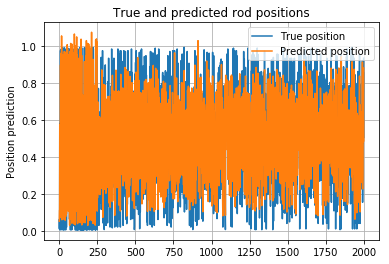

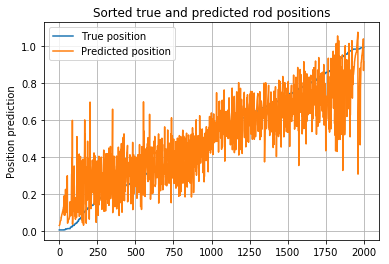

Wrote model to .\RodPosition\pos_cnn_weights_0.hdf
Epoch 2/2


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=1, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=2, workers=50)`


3900/3900 [==============================] - 516s - loss: 0.0253 - mse: 2.5314e-05 - val_loss: 0.0086 - val_mse: 8.6168e-06
Predicted.


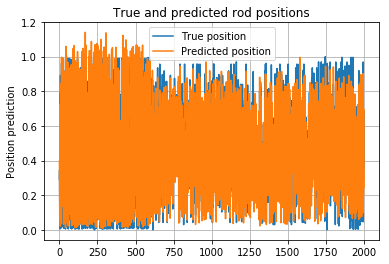

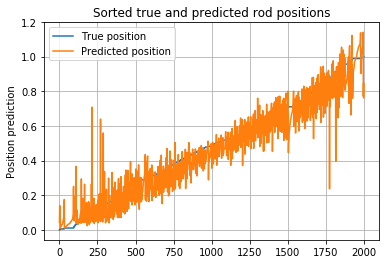

Wrote model to .\RodPosition\pos_cnn_weights_1.hdf
Epoch 3/3


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=2, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=3, workers=50)`


3900/3900 [==============================] - 518s - loss: 0.0194 - mse: 1.9386e-05 - val_loss: 0.0092 - val_mse: 9.1566e-06
Predicted.


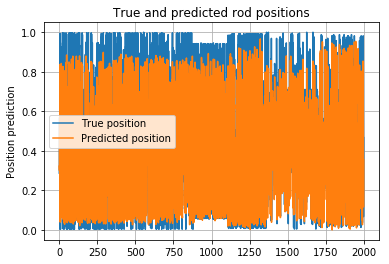

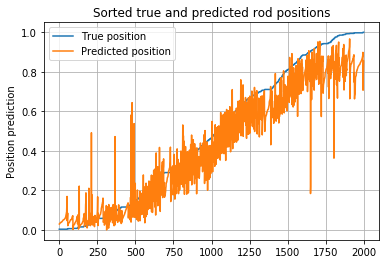

Wrote model to .\RodPosition\pos_cnn_weights_2.hdf
Epoch 4/4


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=3, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=4, workers=50)`


3900/3900 [==============================] - 517s - loss: 0.0162 - mse: 1.6216e-05 - val_loss: 0.0041 - val_mse: 4.0830e-06
Predicted.


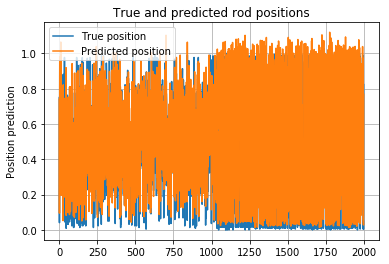

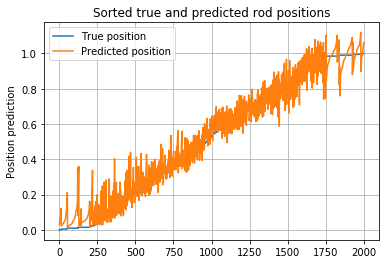

Wrote model to .\RodPosition\pos_cnn_weights_3.hdf
Epoch 5/5


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=4, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=5, workers=50)`


3900/3900 [==============================] - 516s - loss: 0.0144 - mse: 1.4435e-05 - val_loss: 0.0042 - val_mse: 4.2021e-06
Predicted.


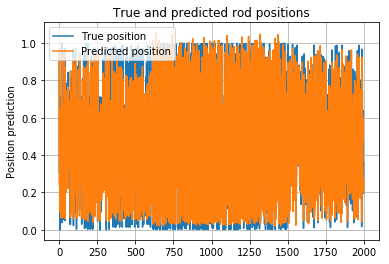

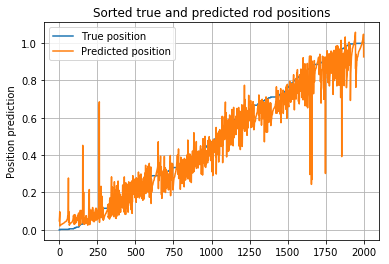

Wrote model to .\RodPosition\pos_cnn_weights_4.hdf
Epoch 6/6


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=5, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=6, workers=50)`


3900/3900 [==============================] - 514s - loss: 0.0131 - mse: 1.3138e-05 - val_loss: 0.0053 - val_mse: 5.2552e-06
Predicted.


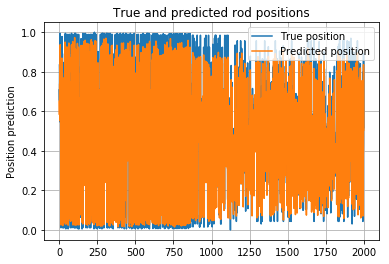

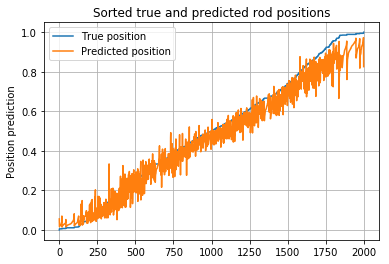

Wrote model to .\RodPosition\pos_cnn_weights_5.hdf
Epoch 7/7


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=6, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=7, workers=50)`


3900/3900 [==============================] - 514s - loss: 0.0124 - mse: 1.2379e-05 - val_loss: 0.0026 - val_mse: 2.6002e-06
Predicted.


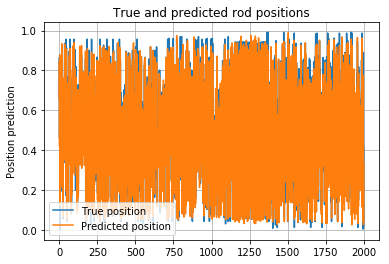

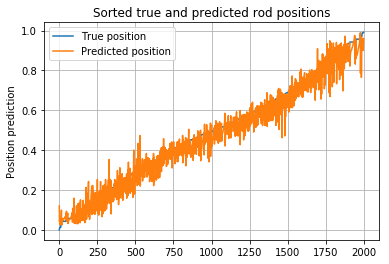

Wrote model to .\RodPosition\pos_cnn_weights_6.hdf
Epoch 8/8


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=7, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=8, workers=50)`


3900/3900 [==============================] - 514s - loss: 0.0115 - mse: 1.1462e-05 - val_loss: 0.0019 - val_mse: 1.9345e-06
Predicted.


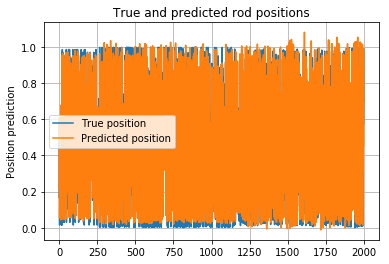

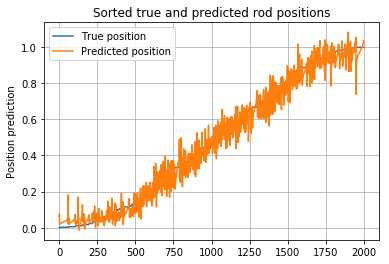

Wrote model to .\RodPosition\pos_cnn_weights_7.hdf
Epoch 9/9


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=8, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=9, workers=50)`


3900/3900 [==============================] - 514s - loss: 0.0110 - mse: 1.0967e-05 - val_loss: 0.0034 - val_mse: 3.4111e-06
Predicted.


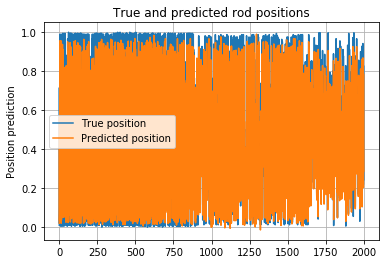

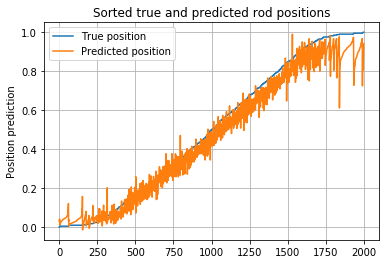

Wrote model to .\RodPosition\pos_cnn_weights_8.hdf
Epoch 10/10


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=9, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=10, workers=50)`


3900/3900 [==============================] - 514s - loss: 0.0105 - mse: 1.0475e-05 - val_loss: 0.0016 - val_mse: 1.6072e-06
Predicted.


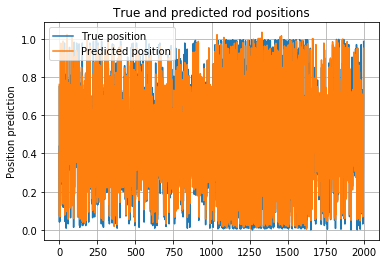

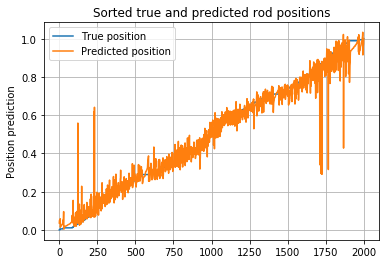

Wrote model to .\RodPosition\pos_cnn_weights_9.hdf
Epoch 11/11


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=10, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=11, workers=50)`


3900/3900 [==============================] - 513s - loss: 0.0099 - mse: 9.9251e-06 - val_loss: 0.0014 - val_mse: 1.4335e-06
Predicted.


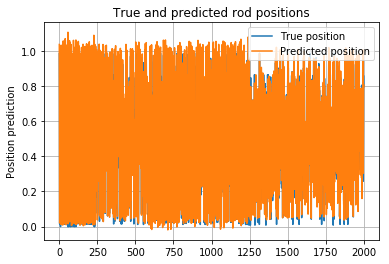

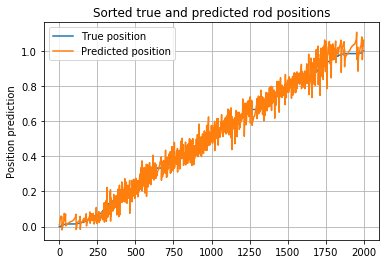

Wrote model to .\RodPosition\pos_cnn_weights_10.hdf
Epoch 12/12


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=11, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=12, workers=50)`


3900/3900 [==============================] - 513s - loss: 0.0098 - mse: 9.7697e-06 - val_loss: 0.0029 - val_mse: 2.8803e-06
Predicted.


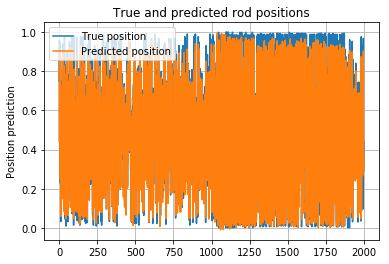

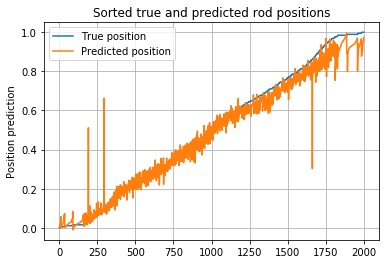

Wrote model to .\RodPosition\pos_cnn_weights_11.hdf
Epoch 13/13


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=12, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=13, workers=50)`


3900/3900 [==============================] - 513s - loss: 0.0092 - mse: 9.1837e-06 - val_loss: 0.0018 - val_mse: 1.7923e-06
Predicted.


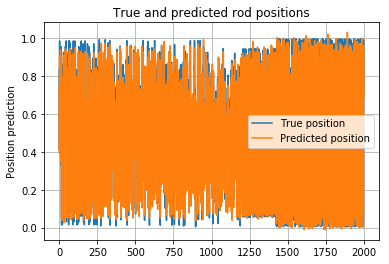

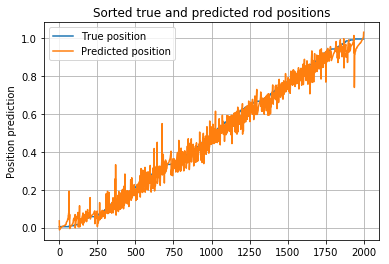

Wrote model to .\RodPosition\pos_cnn_weights_12.hdf
Epoch 14/14


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=13, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=14, workers=50)`


3900/3900 [==============================] - 513s - loss: 0.0089 - mse: 8.9017e-06 - val_loss: 0.0011 - val_mse: 1.1375e-06
Predicted.


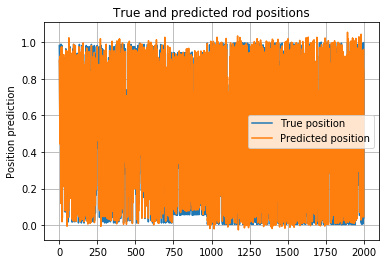

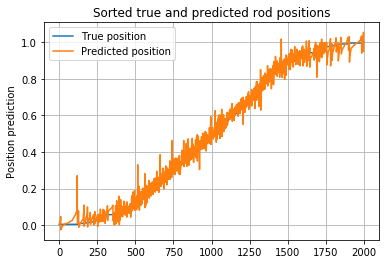

Wrote model to .\RodPosition\pos_cnn_weights_13.hdf
Epoch 15/15


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=14, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=15, workers=50)`


3900/3900 [==============================] - 515s - loss: 0.0084 - mse: 8.3953e-06 - val_loss: 0.0015 - val_mse: 1.4589e-06
Predicted.


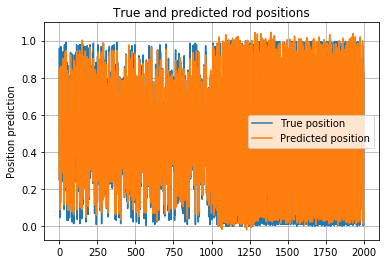

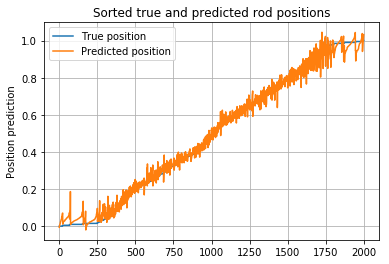

Wrote model to .\RodPosition\pos_cnn_weights_14.hdf
Starting at lr=0.000001
Batch size 10: 3900 training batches, 973 validation batches


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=15, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=16, workers=50)`


Epoch 16/16
3900/3900 [==============================] - 516s - loss: 0.0079 - mse: 7.8602e-06 - val_loss: 0.0012 - val_mse: 1.1515e-06
Predicted.


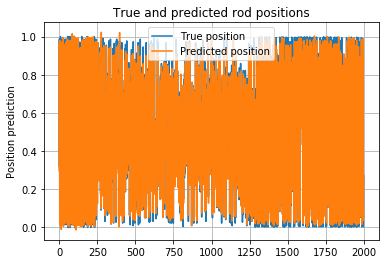

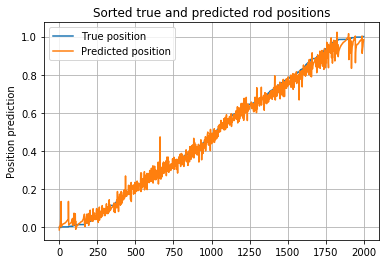

Wrote model to .\RodPosition\pos_cnn_weights_15.hdf
Epoch 17/17


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=16, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=17, workers=50)`


3900/3900 [==============================] - 515s - loss: 0.0078 - mse: 7.8212e-06 - val_loss: 0.0012 - val_mse: 1.1911e-06
Predicted.


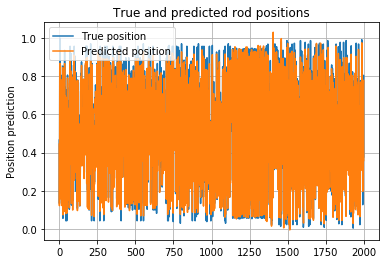

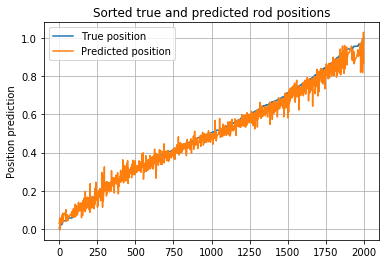

Wrote model to .\RodPosition\pos_cnn_weights_16.hdf
Epoch 18/18


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=17, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=18, workers=50)`


3900/3900 [==============================] - 515s - loss: 0.0075 - mse: 7.5203e-06 - val_loss: 0.0013 - val_mse: 1.3395e-06
Predicted.


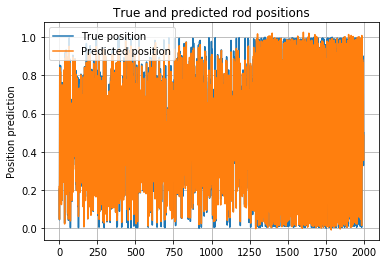

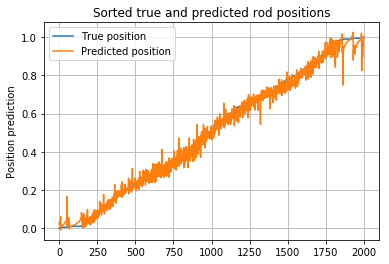

Wrote model to .\RodPosition\pos_cnn_weights_17.hdf
Epoch 19/19


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=18, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=19, workers=50)`


3900/3900 [==============================] - 515s - loss: 0.0077 - mse: 7.6988e-06 - val_loss: 8.8128e-04 - val_mse: 8.8128e-07
Predicted.


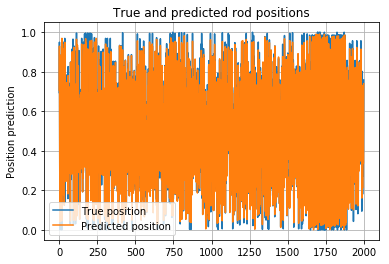

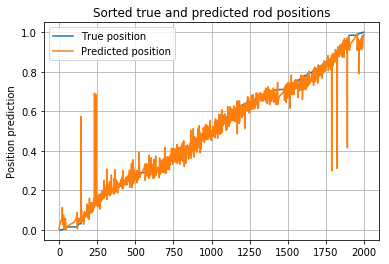

Wrote model to .\RodPosition\pos_cnn_weights_18.hdf
Epoch 20/20


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=19, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=20, workers=50)`


3900/3900 [==============================] - 514s - loss: 0.0076 - mse: 7.6441e-06 - val_loss: 7.3973e-04 - val_mse: 7.3973e-07
Predicted.


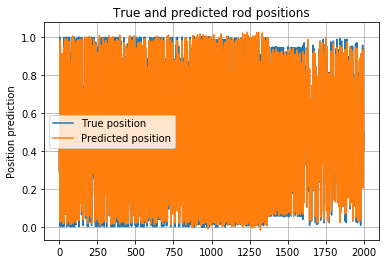

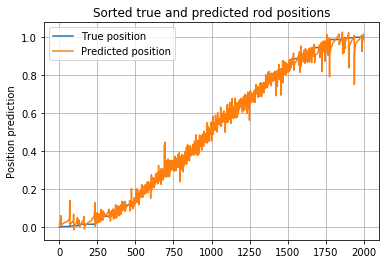

Wrote model to .\RodPosition\pos_cnn_weights_19.hdf
Epoch 21/21


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=20, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=21, workers=50)`


3900/3900 [==============================] - 515s - loss: 0.0076 - mse: 7.5760e-06 - val_loss: 8.1538e-04 - val_mse: 8.1538e-07
Predicted.


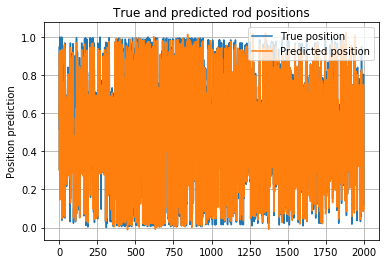

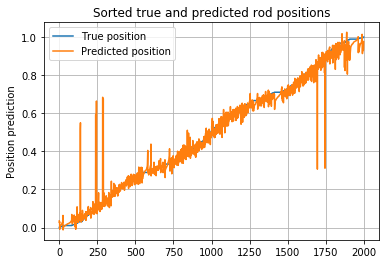

Wrote model to .\RodPosition\pos_cnn_weights_20.hdf
Epoch 22/22


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=21, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=22, workers=50)`


3900/3900 [==============================] - 514s - loss: 0.0077 - mse: 7.6678e-06 - val_loss: 0.0012 - val_mse: 1.2495e-06
Predicted.


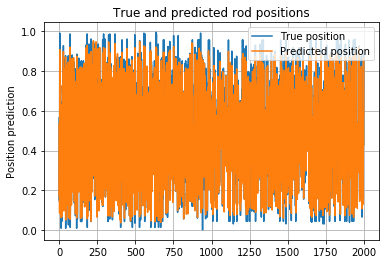

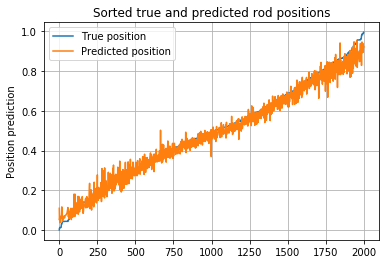

Wrote model to .\RodPosition\pos_cnn_weights_21.hdf
Epoch 23/23


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=22, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=23, workers=50)`


3900/3900 [==============================] - 514s - loss: 0.0075 - mse: 7.5347e-06 - val_loss: 9.1733e-04 - val_mse: 9.1733e-07
Predicted.


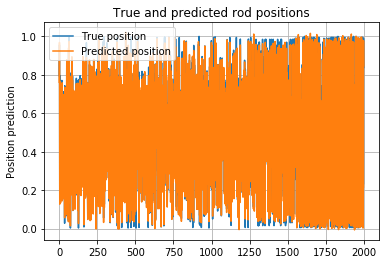

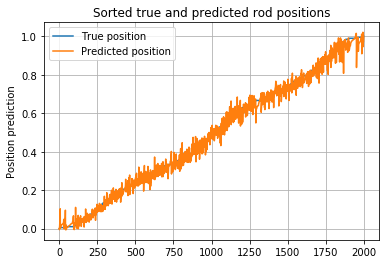

Wrote model to .\RodPosition\pos_cnn_weights_22.hdf
Epoch 24/24


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=23, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=24, workers=50)`


3900/3900 [==============================] - 515s - loss: 0.0074 - mse: 7.4391e-06 - val_loss: 0.0013 - val_mse: 1.3259e-06
Predicted.


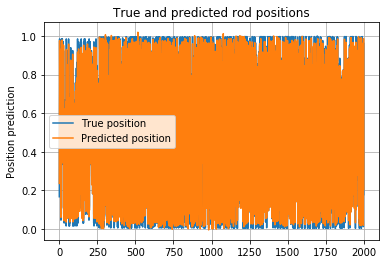

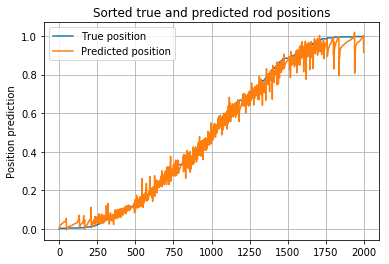

Wrote model to .\RodPosition\pos_cnn_weights_23.hdf
Epoch 25/25


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=24, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=25, workers=50)`


3900/3900 [==============================] - 515s - loss: 0.0075 - mse: 7.5054e-06 - val_loss: 0.0011 - val_mse: 1.0793e-06
Predicted.


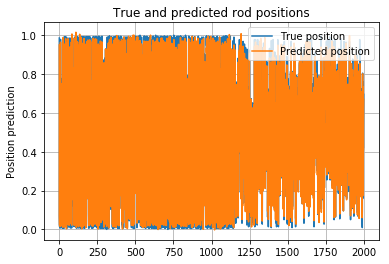

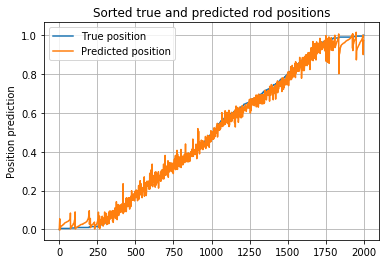

Wrote model to .\RodPosition\pos_cnn_weights_24.hdf
Epoch 26/26


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=25, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=26, workers=50)`


3900/3900 [==============================] - 515s - loss: 0.0073 - mse: 7.2925e-06 - val_loss: 0.0010 - val_mse: 1.0295e-06
Predicted.


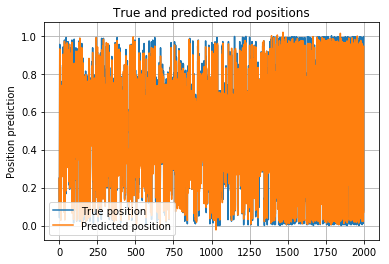

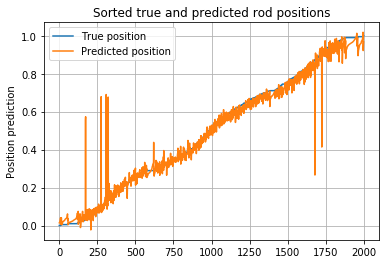

Wrote model to .\RodPosition\pos_cnn_weights_25.hdf
Epoch 27/27


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=26, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=27, workers=50)`


3900/3900 [==============================] - 515s - loss: 0.0074 - mse: 7.4197e-06 - val_loss: 0.0011 - val_mse: 1.1290e-06
Predicted.


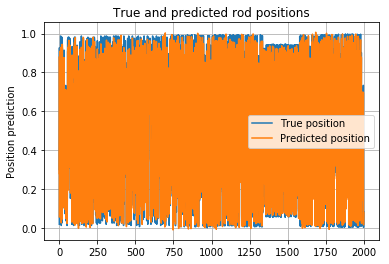

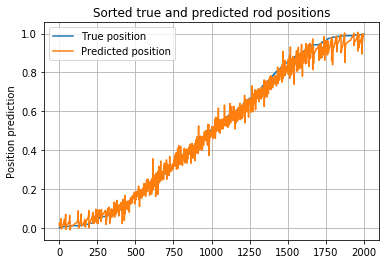

Wrote model to .\RodPosition\pos_cnn_weights_26.hdf
Epoch 28/28


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=27, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=28, workers=50)`


3900/3900 [==============================] - 515s - loss: 0.0074 - mse: 7.3582e-06 - val_loss: 9.0261e-04 - val_mse: 9.0261e-07
Predicted.


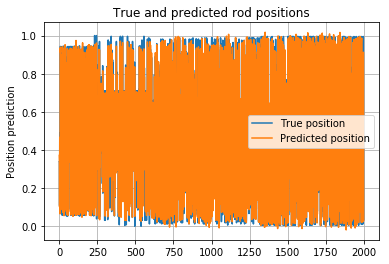

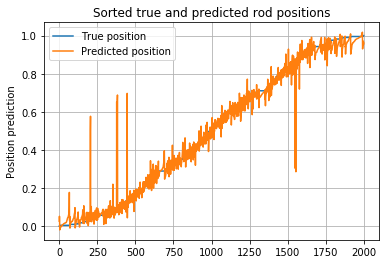

Wrote model to .\RodPosition\pos_cnn_weights_27.hdf
Epoch 29/29


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=28, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=29, workers=50)`


3900/3900 [==============================] - 516s - loss: 0.0073 - mse: 7.3207e-06 - val_loss: 0.0014 - val_mse: 1.4195e-06
Predicted.


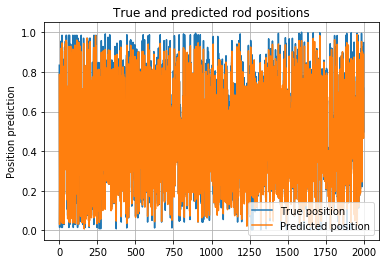

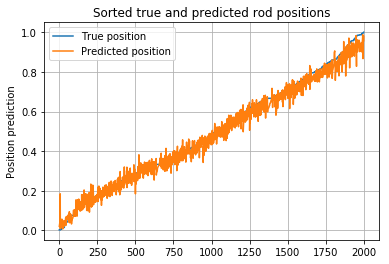

Wrote model to .\RodPosition\pos_cnn_weights_28.hdf
Epoch 30/30


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=29, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=30, workers=50)`


3900/3900 [==============================] - 514s - loss: 0.0073 - mse: 7.2501e-06 - val_loss: 9.5551e-04 - val_mse: 9.5551e-07
Predicted.


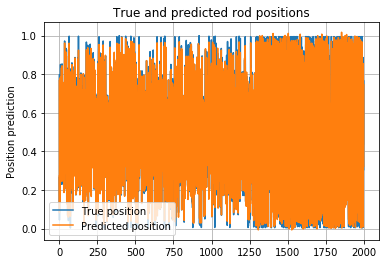

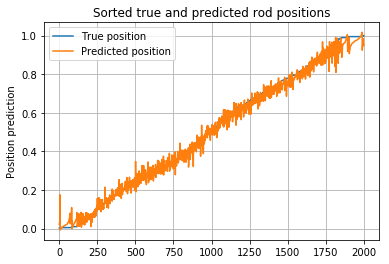

Wrote model to .\RodPosition\pos_cnn_weights_29.hdf
Starting at lr=0.000000
Batch size 10: 3900 training batches, 973 validation batches


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=30, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=31, workers=50)`


Epoch 31/31
3900/3900 [==============================] - 518s - loss: 0.0073 - mse: 7.2792e-06 - val_loss: 0.0012 - val_mse: 1.1998e-06
Predicted.


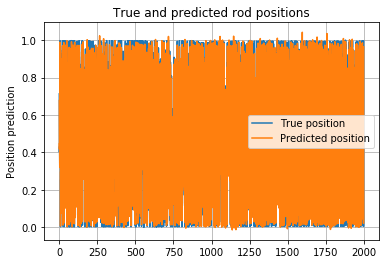

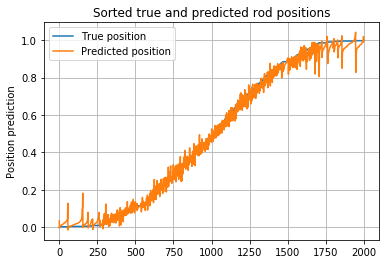

Wrote model to .\RodPosition\pos_cnn_weights_30.hdf
Epoch 32/32


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=31, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=32, workers=50)`


3900/3900 [==============================] - 516s - loss: 0.0072 - mse: 7.1988e-06 - val_loss: 9.8132e-04 - val_mse: 9.8132e-07
Predicted.


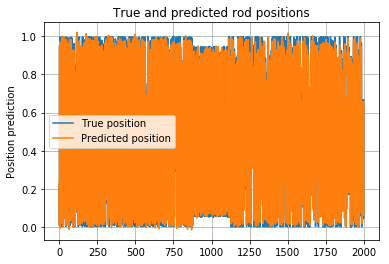

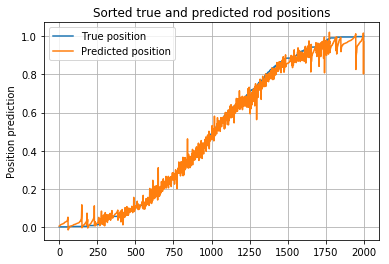

Wrote model to .\RodPosition\pos_cnn_weights_31.hdf
Epoch 33/33


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=32, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=33, workers=50)`


3900/3900 [==============================] - 517s - loss: 0.0072 - mse: 7.2144e-06 - val_loss: 0.0011 - val_mse: 1.0895e-06
Predicted.


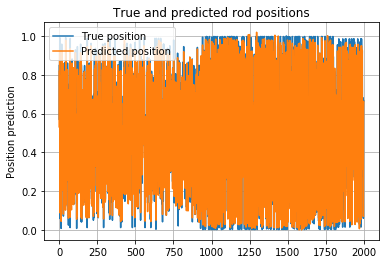

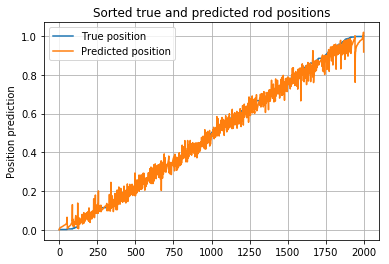

Wrote model to .\RodPosition\pos_cnn_weights_32.hdf
Epoch 34/34


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=33, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=34, workers=50)`


3900/3900 [==============================] - 517s - loss: 0.0073 - mse: 7.2841e-06 - val_loss: 9.2258e-04 - val_mse: 9.2258e-07
Predicted.


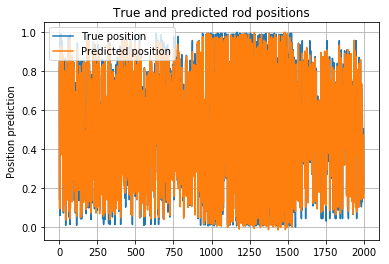

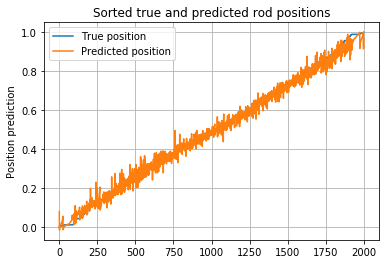

Wrote model to .\RodPosition\pos_cnn_weights_33.hdf
Epoch 35/35


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=34, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=35, workers=50)`


3900/3900 [==============================] - 516s - loss: 0.0072 - mse: 7.2453e-06 - val_loss: 9.9862e-04 - val_mse: 9.9862e-07
Predicted.


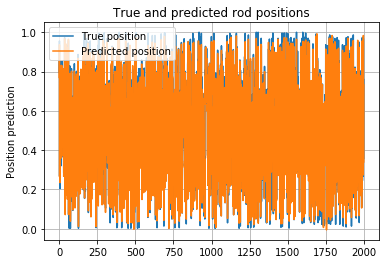

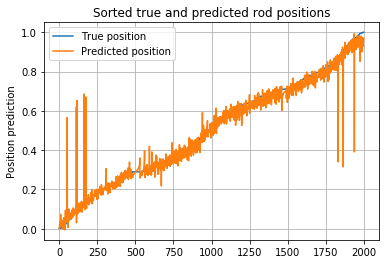

Wrote model to .\RodPosition\pos_cnn_weights_34.hdf
Epoch 36/36


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=35, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=36, workers=50)`


3900/3900 [==============================] - 517s - loss: 0.0073 - mse: 7.2563e-06 - val_loss: 9.3252e-04 - val_mse: 9.3252e-07
Predicted.


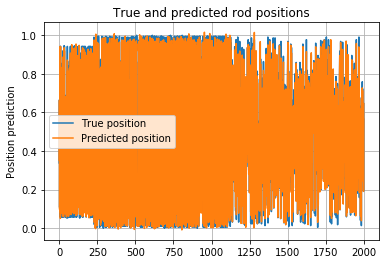

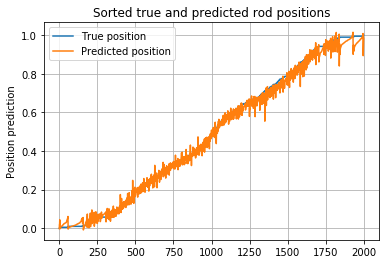

Wrote model to .\RodPosition\pos_cnn_weights_35.hdf
Epoch 37/37


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=36, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=37, workers=50)`


3900/3900 [==============================] - 516s - loss: 0.0073 - mse: 7.2731e-06 - val_loss: 7.2246e-04 - val_mse: 7.2246e-07
Predicted.


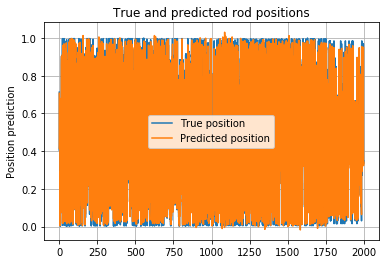

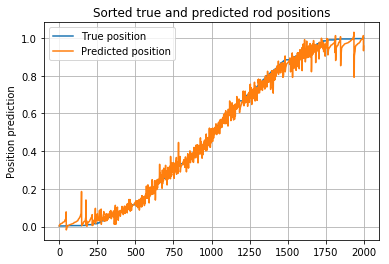

Wrote model to .\RodPosition\pos_cnn_weights_36.hdf
Epoch 38/38


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=37, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=38, workers=50)`


3900/3900 [==============================] - 516s - loss: 0.0072 - mse: 7.1694e-06 - val_loss: 9.9840e-04 - val_mse: 9.9840e-07
Predicted.


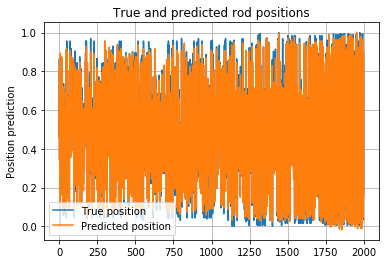

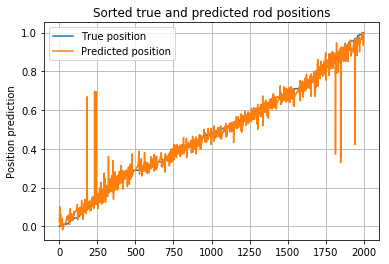

Wrote model to .\RodPosition\pos_cnn_weights_37.hdf
Epoch 39/39


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=38, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=39, workers=50)`


3900/3900 [==============================] - 516s - loss: 0.0074 - mse: 7.3655e-06 - val_loss: 9.5042e-04 - val_mse: 9.5042e-07
Predicted.


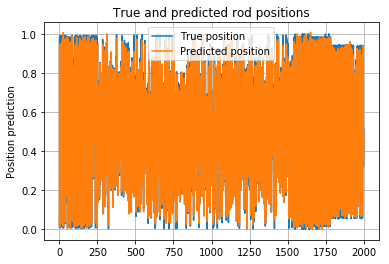

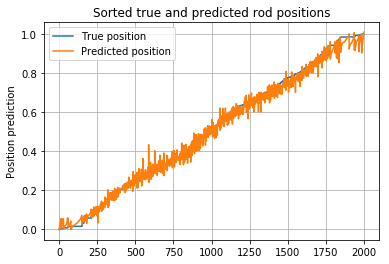

Wrote model to .\RodPosition\pos_cnn_weights_38.hdf
Epoch 40/40


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=39, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=40, workers=50)`


3900/3900 [==============================] - 516s - loss: 0.0071 - mse: 7.1265e-06 - val_loss: 0.0012 - val_mse: 1.2160e-06
Predicted.


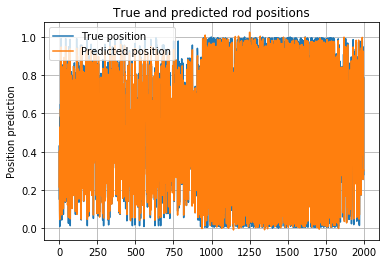

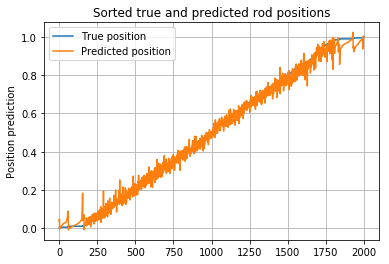

Wrote model to .\RodPosition\pos_cnn_weights_39.hdf
Epoch 41/41


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=40, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=41, workers=50)`


3900/3900 [==============================] - 516s - loss: 0.0072 - mse: 7.2405e-06 - val_loss: 9.7387e-04 - val_mse: 9.7387e-07
Predicted.


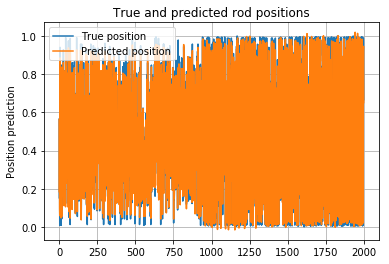

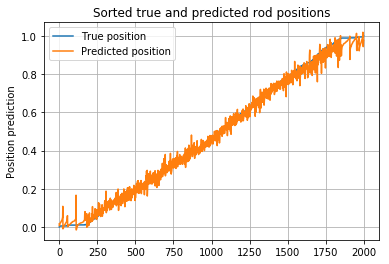

Wrote model to .\RodPosition\pos_cnn_weights_40.hdf
Epoch 42/42


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=41, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=42, workers=50)`


3900/3900 [==============================] - 516s - loss: 0.0072 - mse: 7.1820e-06 - val_loss: 6.7975e-04 - val_mse: 6.7975e-07
Predicted.


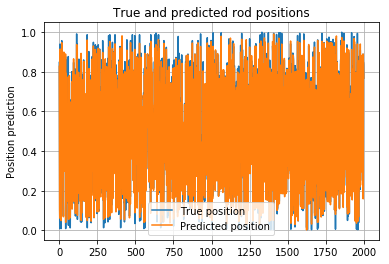

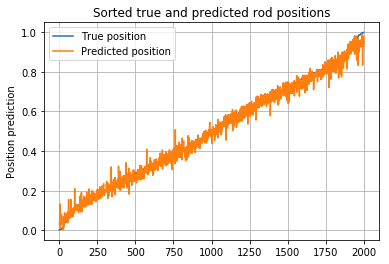

Wrote model to .\RodPosition\pos_cnn_weights_41.hdf
Epoch 43/43


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=42, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=43, workers=50)`


3900/3900 [==============================] - 516s - loss: 0.0071 - mse: 7.1307e-06 - val_loss: 9.3054e-04 - val_mse: 9.3054e-07
Predicted.


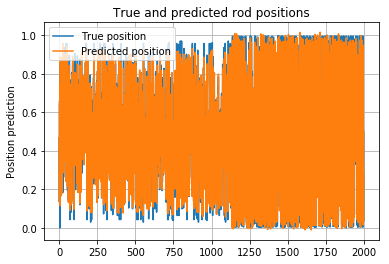

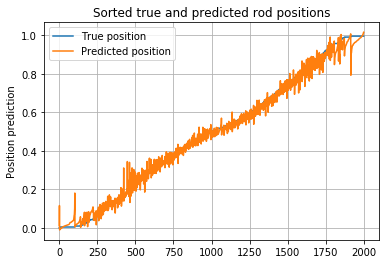

Wrote model to .\RodPosition\pos_cnn_weights_42.hdf
Epoch 44/44


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=43, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=44, workers=50)`


3900/3900 [==============================] - 516s - loss: 0.0073 - mse: 7.2655e-06 - val_loss: 9.6112e-04 - val_mse: 9.6112e-07
Predicted.


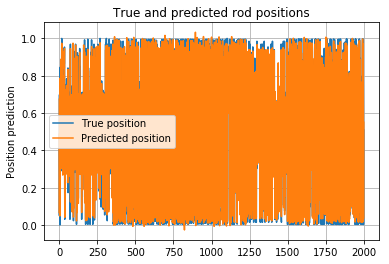

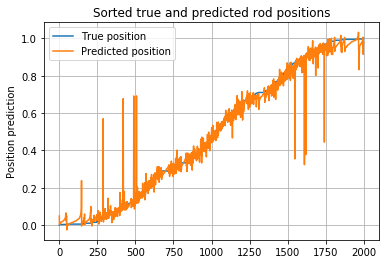

Wrote model to .\RodPosition\pos_cnn_weights_43.hdf
Epoch 45/45


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=44, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=45, workers=50)`


3900/3900 [==============================] - 516s - loss: 0.0072 - mse: 7.1632e-06 - val_loss: 7.1108e-04 - val_mse: 7.1108e-07
Predicted.


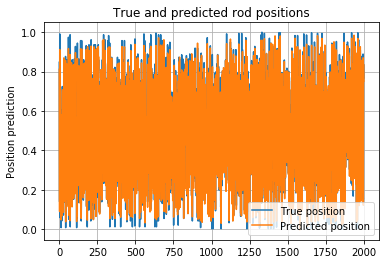

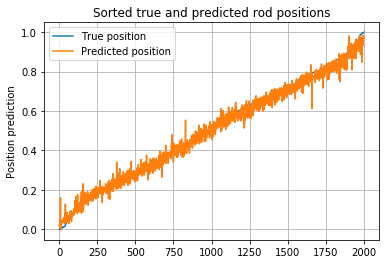

Wrote model to .\RodPosition\pos_cnn_weights_44.hdf
Starting at lr=0.000000
Batch size 10: 3900 training batches, 973 validation batches


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=45, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=46, workers=50)`


Epoch 46/46
3900/3900 [==============================] - 520s - loss: 0.0072 - mse: 7.1959e-06 - val_loss: 9.5334e-04 - val_mse: 9.5334e-07
Predicted.


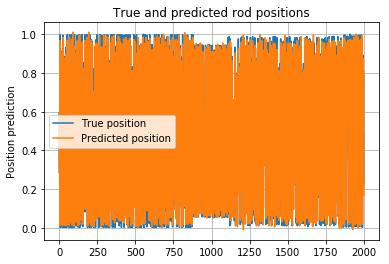

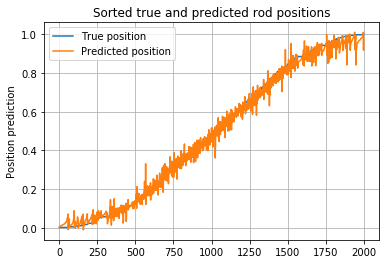

Wrote model to .\RodPosition\pos_cnn_weights_45.hdf
Epoch 47/47


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=46, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=47, workers=50)`


3900/3900 [==============================] - 519s - loss: 0.0073 - mse: 7.3317e-06 - val_loss: 0.0010 - val_mse: 1.0038e-06
Predicted.


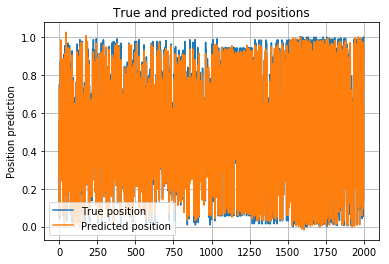

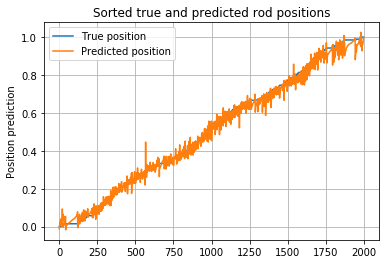

Wrote model to .\RodPosition\pos_cnn_weights_46.hdf
Epoch 48/48


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=47, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=48, workers=50)`


3900/3900 [==============================] - 519s - loss: 0.0074 - mse: 7.3648e-06 - val_loss: 0.0012 - val_mse: 1.2083e-06
Predicted.


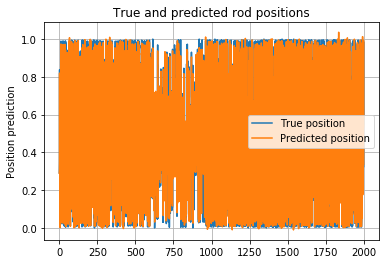

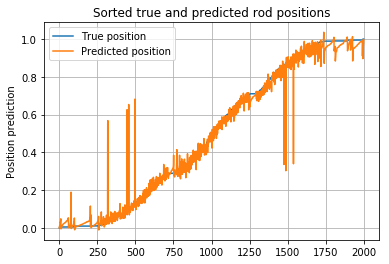

Wrote model to .\RodPosition\pos_cnn_weights_47.hdf
Epoch 49/49


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=48, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=49, workers=50)`


3900/3900 [==============================] - 519s - loss: 0.0072 - mse: 7.1562e-06 - val_loss: 9.6604e-04 - val_mse: 9.6604e-07
Predicted.


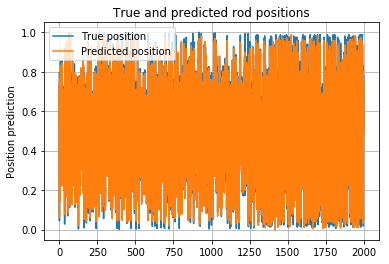

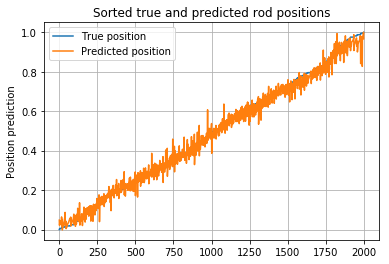

Wrote model to .\RodPosition\pos_cnn_weights_48.hdf
Epoch 50/50


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=49, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=50, workers=50)`


3900/3900 [==============================] - 518s - loss: 0.0071 - mse: 7.1043e-06 - val_loss: 0.0012 - val_mse: 1.1793e-06
Predicted.


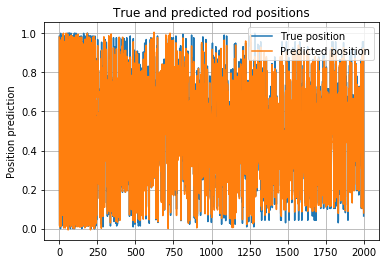

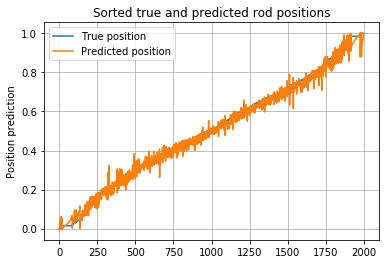

Wrote model to .\RodPosition\pos_cnn_weights_49.hdf
Epoch 51/51


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=50, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=51, workers=50)`


3900/3900 [==============================] - 517s - loss: 0.0071 - mse: 7.0954e-06 - val_loss: 9.6713e-04 - val_mse: 9.6713e-07
Predicted.


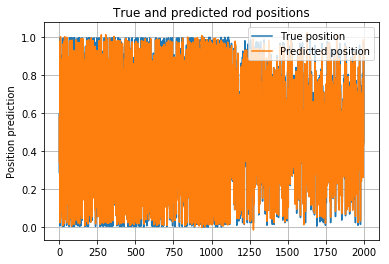

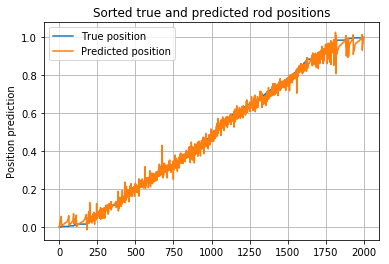

Wrote model to .\RodPosition\pos_cnn_weights_50.hdf
Epoch 52/52


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=51, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=52, workers=50)`


3900/3900 [==============================] - 517s - loss: 0.0072 - mse: 7.2016e-06 - val_loss: 7.3142e-04 - val_mse: 7.3142e-07
Predicted.


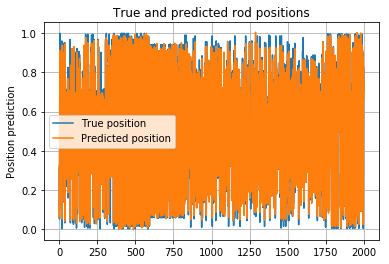

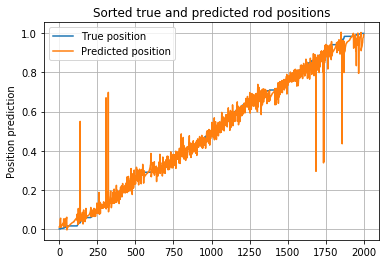

Wrote model to .\RodPosition\pos_cnn_weights_51.hdf
Epoch 53/53


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=52, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=53, workers=50)`


3900/3900 [==============================] - 517s - loss: 0.0072 - mse: 7.2047e-06 - val_loss: 9.6474e-04 - val_mse: 9.6474e-07
Predicted.


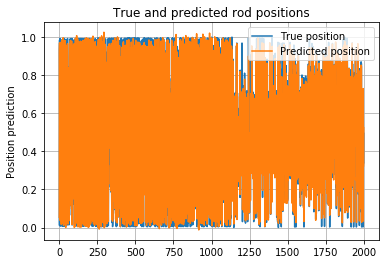

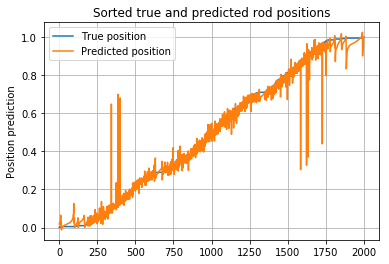

Wrote model to .\RodPosition\pos_cnn_weights_52.hdf
Epoch 54/54


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=53, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=54, workers=50)`


3900/3900 [==============================] - 517s - loss: 0.0072 - mse: 7.2273e-06 - val_loss: 7.1265e-04 - val_mse: 7.1265e-07
Predicted.


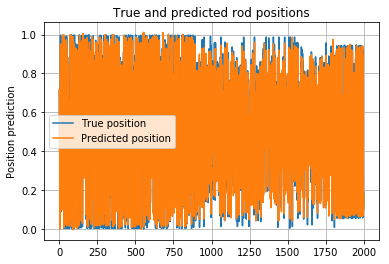

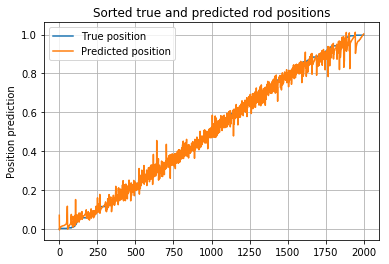

Wrote model to .\RodPosition\pos_cnn_weights_53.hdf
Epoch 55/55


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=54, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=55, workers=50)`


3900/3900 [==============================] - 518s - loss: 0.0071 - mse: 7.0870e-06 - val_loss: 9.7119e-04 - val_mse: 9.7119e-07
Predicted.


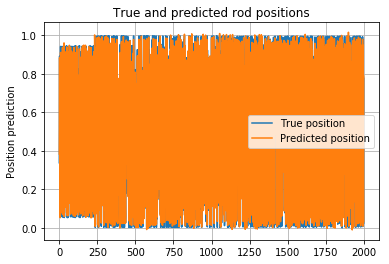

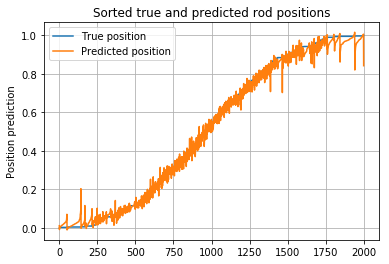

Wrote model to .\RodPosition\pos_cnn_weights_54.hdf
Epoch 56/56


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=55, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=56, workers=50)`


3900/3900 [==============================] - 517s - loss: 0.0072 - mse: 7.1514e-06 - val_loss: 9.0737e-04 - val_mse: 9.0737e-07
Predicted.


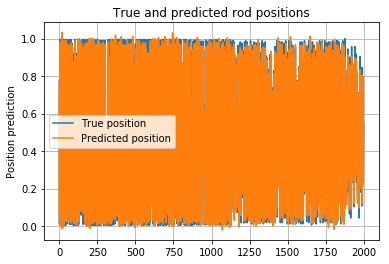

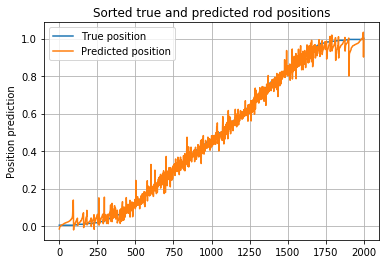

Wrote model to .\RodPosition\pos_cnn_weights_55.hdf
Epoch 57/57


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=56, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=57, workers=50)`


3900/3900 [==============================] - 518s - loss: 0.0072 - mse: 7.2141e-06 - val_loss: 6.9070e-04 - val_mse: 6.9070e-07
Predicted.


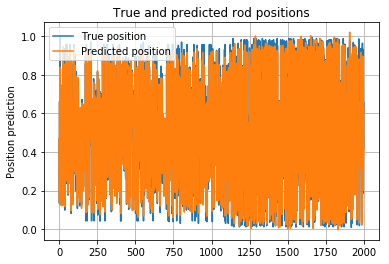

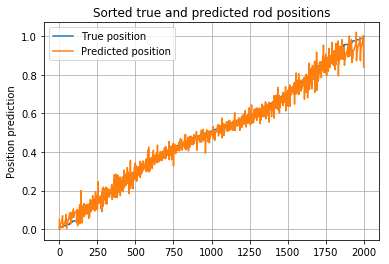

Wrote model to .\RodPosition\pos_cnn_weights_56.hdf
Epoch 58/58


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=57, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=58, workers=50)`


3900/3900 [==============================] - 518s - loss: 0.0072 - mse: 7.2187e-06 - val_loss: 9.5366e-04 - val_mse: 9.5366e-07
Predicted.


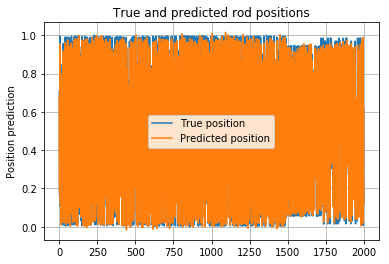

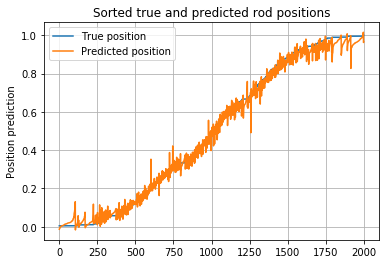

Wrote model to .\RodPosition\pos_cnn_weights_57.hdf
Epoch 59/59


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=58, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=59, workers=50)`


3900/3900 [==============================] - 518s - loss: 0.0072 - mse: 7.1958e-06 - val_loss: 0.0012 - val_mse: 1.1906e-06
Predicted.


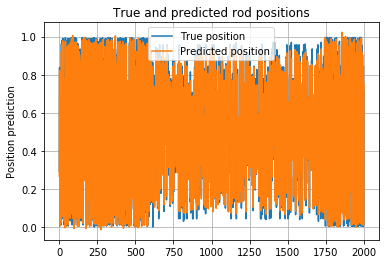

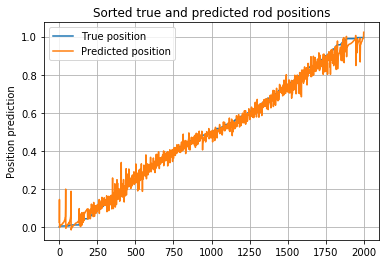

Wrote model to .\RodPosition\pos_cnn_weights_58.hdf
Epoch 60/60


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=59, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=60, workers=50)`


3900/3900 [==============================] - 517s - loss: 0.0071 - mse: 7.1164e-06 - val_loss: 0.0012 - val_mse: 1.1932e-06
Predicted.


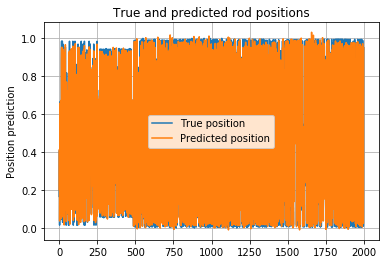

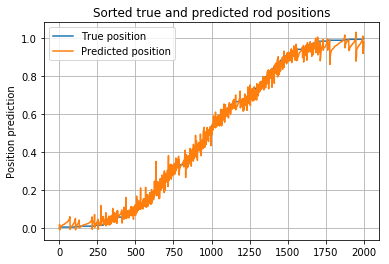

Wrote model to .\RodPosition\pos_cnn_weights_59.hdf
Starting at lr=0.000000
Batch size 10: 3900 training batches, 973 validation batches


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=60, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=61, workers=50)`


Epoch 61/61
3900/3900 [==============================] - 518s - loss: 0.0071 - mse: 7.1197e-06 - val_loss: 9.6487e-04 - val_mse: 9.6487e-07
Predicted.


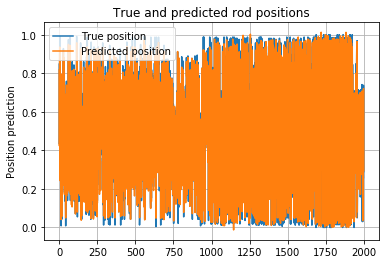

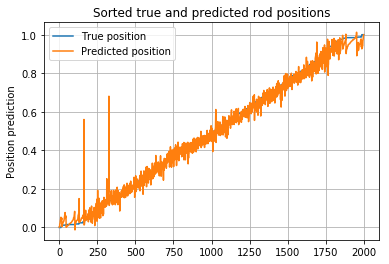

Wrote model to .\RodPosition\pos_cnn_weights_60.hdf
Epoch 62/62


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=61, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=62, workers=50)`


3900/3900 [==============================] - 516s - loss: 0.0072 - mse: 7.1908e-06 - val_loss: 9.1353e-04 - val_mse: 9.1353e-07
Predicted.


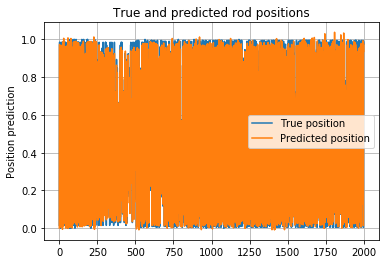

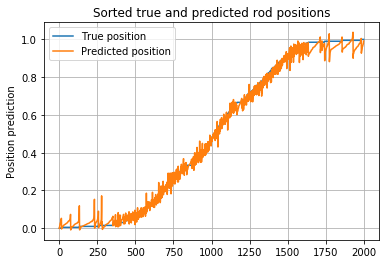

Wrote model to .\RodPosition\pos_cnn_weights_61.hdf
Epoch 63/63


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=62, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=63, workers=50)`


3900/3900 [==============================] - 517s - loss: 0.0071 - mse: 7.1447e-06 - val_loss: 9.5535e-04 - val_mse: 9.5535e-07
Predicted.


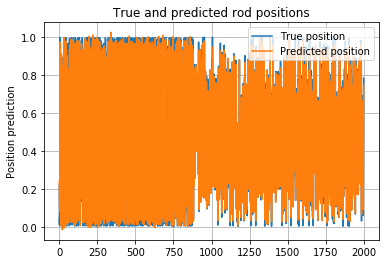

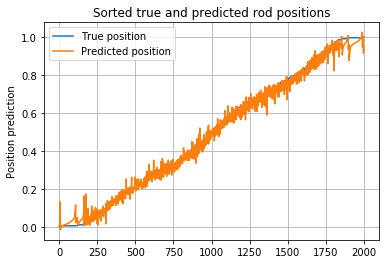

Wrote model to .\RodPosition\pos_cnn_weights_62.hdf
Epoch 64/64


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=63, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=64, workers=50)`


3900/3900 [==============================] - 517s - loss: 0.0072 - mse: 7.1518e-06 - val_loss: 9.5360e-04 - val_mse: 9.5360e-07
Predicted.


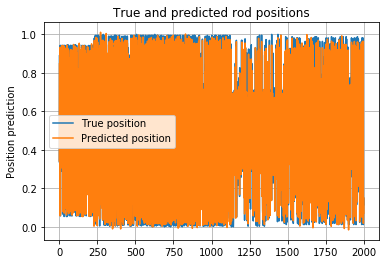

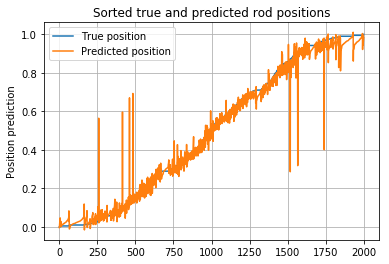

Wrote model to .\RodPosition\pos_cnn_weights_63.hdf
Epoch 65/65


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=64, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=65, workers=50)`


3900/3900 [==============================] - 517s - loss: 0.0072 - mse: 7.1957e-06 - val_loss: 9.9924e-04 - val_mse: 9.9924e-07
Predicted.


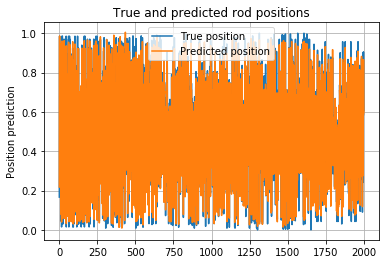

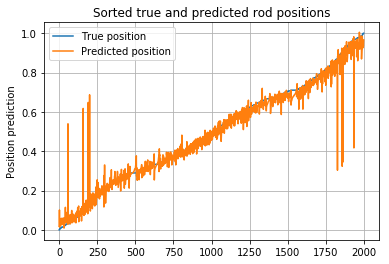

Wrote model to .\RodPosition\pos_cnn_weights_64.hdf
Epoch 66/66


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=65, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=66, workers=50)`


3900/3900 [==============================] - 518s - loss: 0.0073 - mse: 7.2781e-06 - val_loss: 9.8909e-04 - val_mse: 9.8909e-07
Predicted.


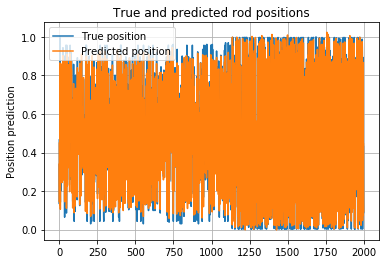

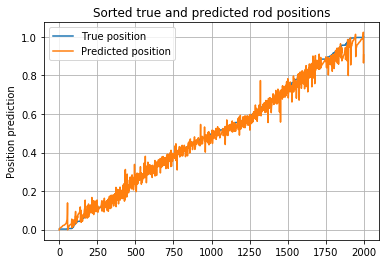

Wrote model to .\RodPosition\pos_cnn_weights_65.hdf
Epoch 67/67


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=66, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=67, workers=50)`


3900/3900 [==============================] - 517s - loss: 0.0072 - mse: 7.1936e-06 - val_loss: 9.6789e-04 - val_mse: 9.6789e-07
Predicted.


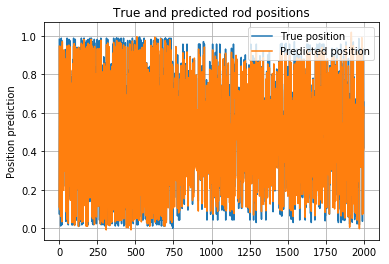

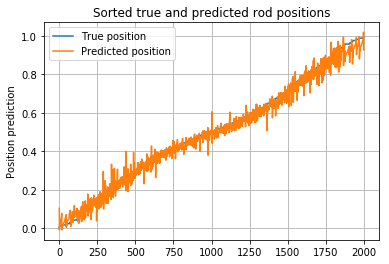

Wrote model to .\RodPosition\pos_cnn_weights_66.hdf
Epoch 68/68


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=67, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=68, workers=50)`


3900/3900 [==============================] - 517s - loss: 0.0071 - mse: 7.1162e-06 - val_loss: 9.7916e-04 - val_mse: 9.7916e-07
Predicted.


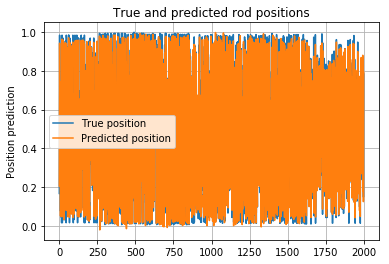

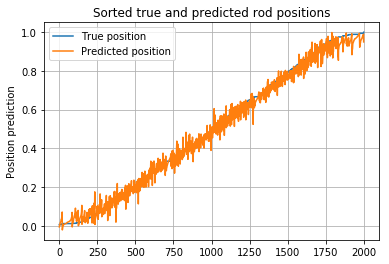

Wrote model to .\RodPosition\pos_cnn_weights_67.hdf
Epoch 69/69


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=68, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=69, workers=50)`


3900/3900 [==============================] - 517s - loss: 0.0073 - mse: 7.2616e-06 - val_loss: 9.8384e-04 - val_mse: 9.8384e-07
Predicted.


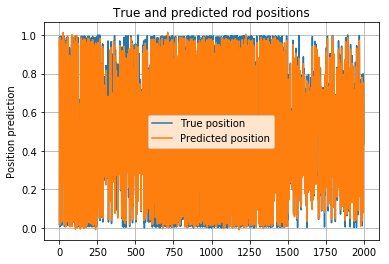

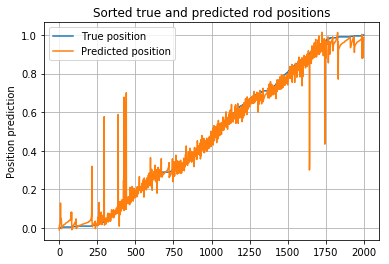

Wrote model to .\RodPosition\pos_cnn_weights_68.hdf
Epoch 70/70


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=69, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=70, workers=50)`


3900/3900 [==============================] - 518s - loss: 0.0073 - mse: 7.2897e-06 - val_loss: 0.0010 - val_mse: 1.0436e-06
Predicted.


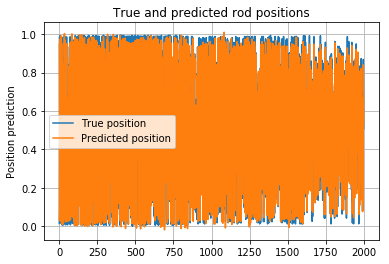

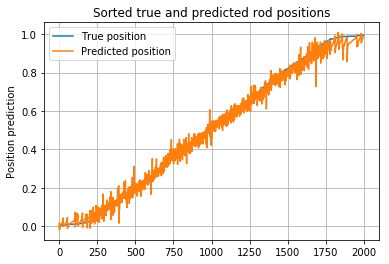

Wrote model to .\RodPosition\pos_cnn_weights_69.hdf
Epoch 71/71


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=70, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=71, workers=50)`


3900/3900 [==============================] - 517s - loss: 0.0072 - mse: 7.2133e-06 - val_loss: 7.4818e-04 - val_mse: 7.4818e-07
Predicted.


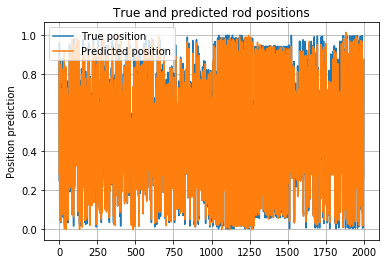

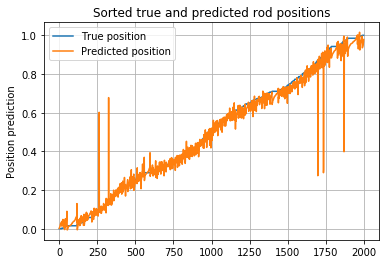

Wrote model to .\RodPosition\pos_cnn_weights_70.hdf
Epoch 72/72


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=71, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=72, workers=50)`


3900/3900 [==============================] - 517s - loss: 0.0073 - mse: 7.2814e-06 - val_loss: 9.9462e-04 - val_mse: 9.9462e-07
Predicted.


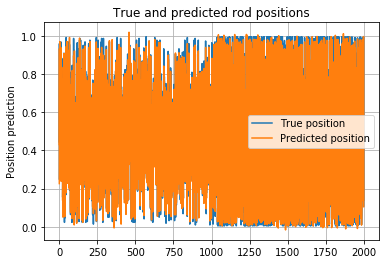

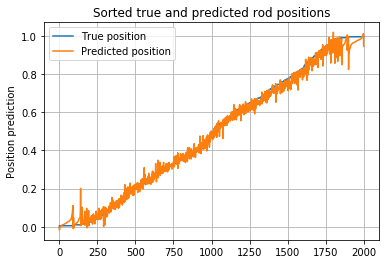

Wrote model to .\RodPosition\pos_cnn_weights_71.hdf
Epoch 73/73


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=72, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=73, workers=50)`


3900/3900 [==============================] - 519s - loss: 0.0072 - mse: 7.2312e-06 - val_loss: 7.9018e-04 - val_mse: 7.9018e-07
Predicted.


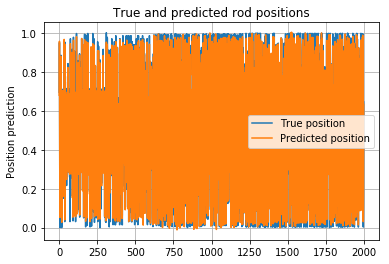

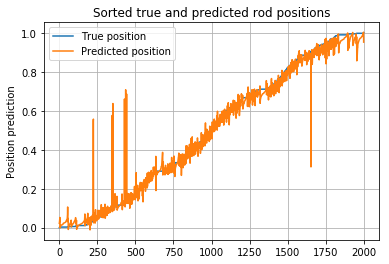

Wrote model to .\RodPosition\pos_cnn_weights_72.hdf
Epoch 74/74


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:227: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 3900, initial_epoch=73, validation_data=<__main__...., class_weight=None, validation_steps=973, callbacks=None, max_queue_size=50, verbose=1, epochs=74, workers=50)`


  75/3900 [..............................] - ETA: 451s - loss: 0.0068 - mse: 6.8425e-06
User stopped the training.


In [19]:

batch_size = 10

epoch = 0
(epoch, stop) = run_train(model, batch_size, training, lr=0.00001,start_epoch=epoch, num_epochs=15, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=1)
if not stop:
    (epoch, stop) = run_train(model, batch_size, training, lr=0.000001,start_epoch=epoch, num_epochs=15, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=1)
if not stop:
    (epoch, stop) = run_train(model, batch_size, training, lr=0.0000001,start_epoch=epoch, num_epochs=15, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=1)
if not stop:
    (epoch, stop) = run_train(model, batch_size, training, lr=0.00000001,start_epoch=epoch, num_epochs=15, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=1)
if not stop:
    (epoch, stop) = run_train(model, batch_size, training, lr=0.000000001,start_epoch=epoch, num_epochs=150, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=1)


Loaded model.
Starting at lr=0.000001
Batch size 200: 195 training batches, 48 validation batches


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=80, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=79, workers=50, validation_steps=48)`


Epoch 80/80
195/195 [==============================] - 529s - loss: 5.8651e-05 - me: 5.8651e-05 - mse: 7.2678e-06 - val_loss: 1.9719e-05 - val_me: 1.9719e-05 - val_mse: 8.1561e-07
Wrote model to .\RodPosition\pos_cnn_weights_79.hdf
Epoch 81/81


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=81, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=80, workers=50, validation_steps=48)`


195/195 [==============================] - 506s - loss: 5.8269e-05 - me: 5.8269e-05 - mse: 7.1370e-06 - val_loss: 1.9648e-05 - val_me: 1.9648e-05 - val_mse: 8.6818e-07
Predicted.


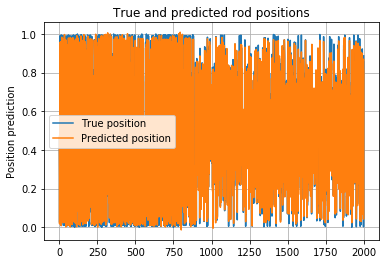

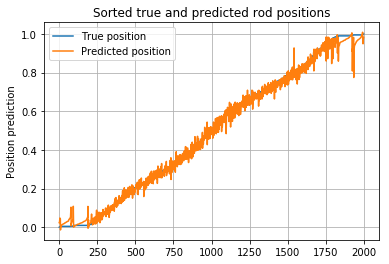

Wrote model to .\RodPosition\pos_cnn_weights_80.hdf
Epoch 82/82


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=82, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=81, workers=50, validation_steps=48)`


195/195 [==============================] - 506s - loss: 5.8471e-05 - me: 5.8471e-05 - mse: 7.2484e-06 - val_loss: 2.0587e-05 - val_me: 2.0587e-05 - val_mse: 8.7889e-07
Wrote model to .\RodPosition\pos_cnn_weights_81.hdf
Epoch 83/83


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=83, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=82, workers=50, validation_steps=48)`


195/195 [==============================] - 506s - loss: 5.8353e-05 - me: 5.8353e-05 - mse: 7.1599e-06 - val_loss: 1.9694e-05 - val_me: 1.9694e-05 - val_mse: 8.0444e-07
Wrote model to .\RodPosition\pos_cnn_weights_82.hdf
Epoch 84/84


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=84, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=83, workers=50, validation_steps=48)`


195/195 [==============================] - 506s - loss: 5.8658e-05 - me: 5.8658e-05 - mse: 7.2386e-06 - val_loss: 2.1521e-05 - val_me: 2.1521e-05 - val_mse: 9.7371e-07
Wrote model to .\RodPosition\pos_cnn_weights_83.hdf
Epoch 85/85


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=85, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=84, workers=50, validation_steps=48)`


195/195 [==============================] - 507s - loss: 5.8403e-05 - me: 5.8403e-05 - mse: 7.1937e-06 - val_loss: 1.8060e-05 - val_me: 1.8060e-05 - val_mse: 8.2155e-07
Wrote model to .\RodPosition\pos_cnn_weights_84.hdf
Epoch 86/86


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=86, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=85, workers=50, validation_steps=48)`


195/195 [==============================] - 506s - loss: 5.7975e-05 - me: 5.7975e-05 - mse: 7.1661e-06 - val_loss: 1.9768e-05 - val_me: 1.9768e-05 - val_mse: 8.2013e-07
Predicted.


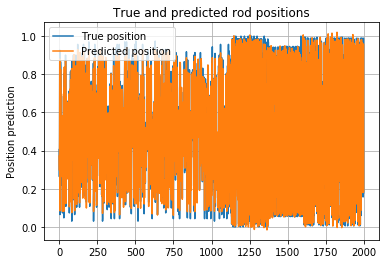

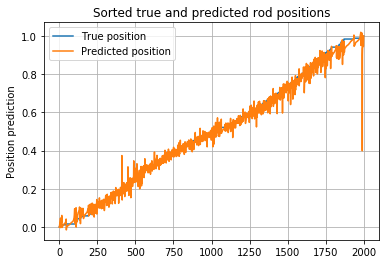

Wrote model to .\RodPosition\pos_cnn_weights_85.hdf
Epoch 87/87


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=87, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=86, workers=50, validation_steps=48)`


195/195 [==============================] - 506s - loss: 5.7630e-05 - me: 5.7630e-05 - mse: 7.0523e-06 - val_loss: 1.9792e-05 - val_me: 1.9792e-05 - val_mse: 8.1430e-07
Wrote model to .\RodPosition\pos_cnn_weights_86.hdf
Epoch 88/88


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=88, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=87, workers=50, validation_steps=48)`


195/195 [==============================] - 506s - loss: 5.8090e-05 - me: 5.8090e-05 - mse: 7.1823e-06 - val_loss: 1.8866e-05 - val_me: 1.8866e-05 - val_mse: 8.1924e-07
Wrote model to .\RodPosition\pos_cnn_weights_87.hdf
Epoch 89/89


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=89, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=88, workers=50, validation_steps=48)`


195/195 [==============================] - 506s - loss: 5.8218e-05 - me: 5.8218e-05 - mse: 7.1785e-06 - val_loss: 2.2419e-05 - val_me: 2.2419e-05 - val_mse: 1.0476e-06
Wrote model to .\RodPosition\pos_cnn_weights_88.hdf
Epoch 90/90


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=90, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=89, workers=50, validation_steps=48)`


195/195 [==============================] - 506s - loss: 5.8013e-05 - me: 5.8013e-05 - mse: 7.1176e-06 - val_loss: 2.1554e-05 - val_me: 2.1554e-05 - val_mse: 1.1157e-06
Wrote model to .\RodPosition\pos_cnn_weights_89.hdf
Epoch 91/91


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=91, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=90, workers=50, validation_steps=48)`


195/195 [==============================] - 506s - loss: 5.7311e-05 - me: 5.7311e-05 - mse: 6.9683e-06 - val_loss: 1.8255e-05 - val_me: 1.8255e-05 - val_mse: 6.9929e-07
Predicted.


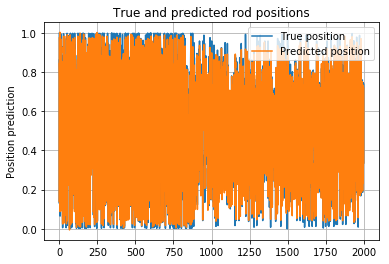

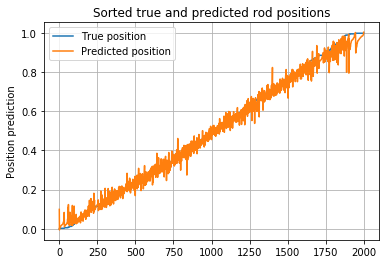

Wrote model to .\RodPosition\pos_cnn_weights_90.hdf
Epoch 92/92


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=92, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=91, workers=50, validation_steps=48)`


195/195 [==============================] - 507s - loss: 5.7843e-05 - me: 5.7843e-05 - mse: 7.0895e-06 - val_loss: 2.0182e-05 - val_me: 2.0182e-05 - val_mse: 7.8062e-07
Wrote model to .\RodPosition\pos_cnn_weights_91.hdf
Epoch 93/93


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=93, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=92, workers=50, validation_steps=48)`


195/195 [==============================] - 506s - loss: 5.7440e-05 - me: 5.7440e-05 - mse: 6.9689e-06 - val_loss: 2.1012e-05 - val_me: 2.1012e-05 - val_mse: 9.0622e-07
Wrote model to .\RodPosition\pos_cnn_weights_92.hdf
Epoch 94/94


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=94, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=93, workers=50, validation_steps=48)`


195/195 [==============================] - 506s - loss: 5.7843e-05 - me: 5.7843e-05 - mse: 7.1388e-06 - val_loss: 2.2394e-05 - val_me: 2.2394e-05 - val_mse: 1.0750e-06
Wrote model to .\RodPosition\pos_cnn_weights_93.hdf
Starting at lr=0.000000
Batch size 200: 195 training batches, 48 validation batches


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=95, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=94, workers=50, validation_steps=48)`


Epoch 95/95
195/195 [==============================] - 508s - loss: 5.7438e-05 - me: 5.7438e-05 - mse: 7.0239e-06 - val_loss: 1.9827e-05 - val_me: 1.9827e-05 - val_mse: 9.0702e-07
Wrote model to .\RodPosition\pos_cnn_weights_94.hdf
Epoch 96/96


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=96, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=95, workers=50, validation_steps=48)`


195/195 [==============================] - 507s - loss: 5.7456e-05 - me: 5.7456e-05 - mse: 6.9677e-06 - val_loss: 1.9866e-05 - val_me: 1.9866e-05 - val_mse: 8.9236e-07
Predicted.


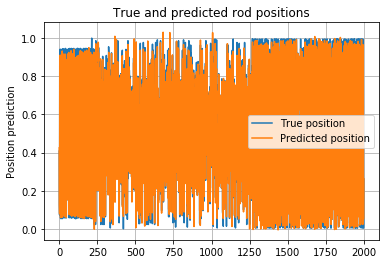

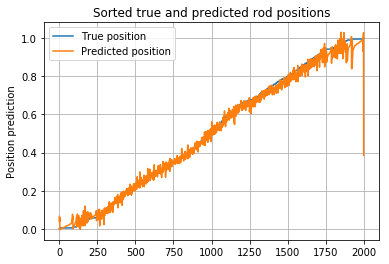

Wrote model to .\RodPosition\pos_cnn_weights_95.hdf
Epoch 97/97


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=97, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=96, workers=50, validation_steps=48)`


195/195 [==============================] - 506s - loss: 5.7743e-05 - me: 5.7743e-05 - mse: 7.0965e-06 - val_loss: 2.0491e-05 - val_me: 2.0491e-05 - val_mse: 9.2772e-07
Wrote model to .\RodPosition\pos_cnn_weights_96.hdf
Epoch 98/98


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=98, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=97, workers=50, validation_steps=48)`


195/195 [==============================] - 506s - loss: 5.7685e-05 - me: 5.7685e-05 - mse: 7.0834e-06 - val_loss: 2.0119e-05 - val_me: 2.0119e-05 - val_mse: 8.8040e-07
Wrote model to .\RodPosition\pos_cnn_weights_97.hdf
Epoch 99/99


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=99, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=98, workers=50, validation_steps=48)`


195/195 [==============================] - 507s - loss: 5.7532e-05 - me: 5.7532e-05 - mse: 7.0759e-06 - val_loss: 2.0001e-05 - val_me: 2.0001e-05 - val_mse: 8.1534e-07
Wrote model to .\RodPosition\pos_cnn_weights_98.hdf
Epoch 100/100


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=100, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=99, workers=50, validation_steps=48)`


195/195 [==============================] - 506s - loss: 5.7553e-05 - me: 5.7553e-05 - mse: 7.0404e-06 - val_loss: 1.9935e-05 - val_me: 1.9935e-05 - val_mse: 9.3742e-07
Wrote model to .\RodPosition\pos_cnn_weights_99.hdf
Epoch 101/101


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=101, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=100, workers=50, validation_steps=48)`


195/195 [==============================] - 506s - loss: 5.7107e-05 - me: 5.7107e-05 - mse: 6.9313e-06 - val_loss: 1.9464e-05 - val_me: 1.9464e-05 - val_mse: 8.2457e-07
Predicted.


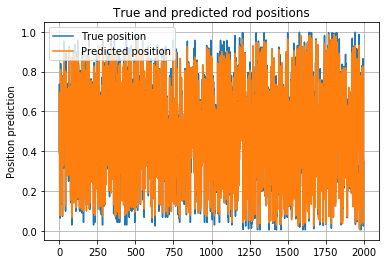

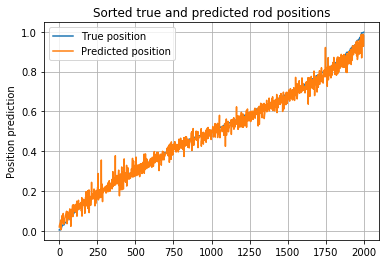

Wrote model to .\RodPosition\pos_cnn_weights_100.hdf
Epoch 102/102


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=102, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=101, workers=50, validation_steps=48)`


195/195 [==============================] - 506s - loss: 5.7559e-05 - me: 5.7559e-05 - mse: 7.0750e-06 - val_loss: 1.8907e-05 - val_me: 1.8907e-05 - val_mse: 8.1073e-07
Wrote model to .\RodPosition\pos_cnn_weights_101.hdf
Epoch 103/103


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=103, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=102, workers=50, validation_steps=48)`


195/195 [==============================] - 506s - loss: 5.8003e-05 - me: 5.8003e-05 - mse: 7.2135e-06 - val_loss: 2.0124e-05 - val_me: 2.0124e-05 - val_mse: 8.5246e-07
Wrote model to .\RodPosition\pos_cnn_weights_102.hdf
Epoch 104/104


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=104, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=103, workers=50, validation_steps=48)`


195/195 [==============================] - 501s - loss: 5.7669e-05 - me: 5.7669e-05 - mse: 7.0149e-06 - val_loss: 2.0840e-05 - val_me: 2.0840e-05 - val_mse: 1.0170e-06
Wrote model to .\RodPosition\pos_cnn_weights_103.hdf
Epoch 105/105


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=105, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=104, workers=50, validation_steps=48)`


121/195 [=================>............] - ETA: 150s - loss: 5.7593e-05 - me: 5.7593e-05 - mse: 7.0757e-06
User stopped the training.


In [11]:
# Load the best model result
epoch = 79
model.load_weights(WEIGHTS_FNAME % epoch, by_name=True)
print("Loaded model.")


batch_size = 200

(epoch, stop) = run_train(model, batch_size, training, lr=0.000001,start_epoch=epoch, num_epochs=15, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=5)
if not stop:
    (epoch, stop) = run_train(model, batch_size, training, lr=0.0000001,start_epoch=epoch, num_epochs=15, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=5)
if not stop:
    (epoch, stop) = run_train(model, batch_size, training, lr=0.00000001,start_epoch=epoch, num_epochs=15, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=5)
if not stop:
    (epoch, stop) = run_train(model, batch_size, training, lr=0.000000001,start_epoch=epoch, num_epochs=15, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=5)


Starting at lr=0.000100
Batch size 200: 195 training batches, 48 validation batches


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=106, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=105, workers=50, validation_steps=48)`


Epoch 106/106
195/195 [==============================] - 506s - loss: 8.7779e-05 - me: 8.7779e-05 - mse: 1.5606e-05 - val_loss: 3.0613e-05 - val_me: 3.0613e-05 - val_mse: 1.7180e-06
Predicted.


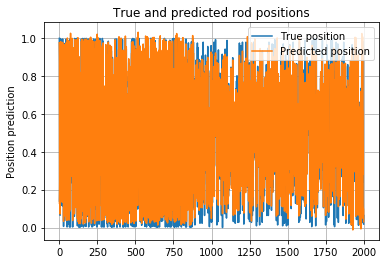

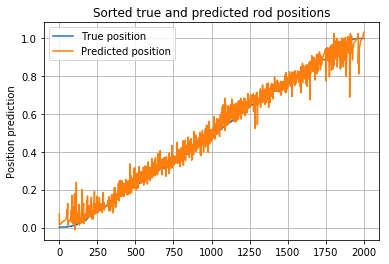

Wrote model to .\RodPosition\pos_cnn_weights_105.hdf
Epoch 107/107


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=107, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=106, workers=50, validation_steps=48)`


195/195 [==============================] - 505s - loss: 7.1108e-05 - me: 7.1108e-05 - mse: 9.8085e-06 - val_loss: 2.8747e-05 - val_me: 2.8747e-05 - val_mse: 1.7435e-06
Wrote model to .\RodPosition\pos_cnn_weights_106.hdf
Epoch 108/108


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=108, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=107, workers=50, validation_steps=48)`


195/195 [==============================] - 504s - loss: 6.6561e-05 - me: 6.6561e-05 - mse: 8.8531e-06 - val_loss: 2.5760e-05 - val_me: 2.5760e-05 - val_mse: 1.2469e-06
Wrote model to .\RodPosition\pos_cnn_weights_107.hdf
Epoch 109/109


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=109, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=108, workers=50, validation_steps=48)`


195/195 [==============================] - 504s - loss: 6.3826e-05 - me: 6.3826e-05 - mse: 8.2311e-06 - val_loss: 3.8095e-05 - val_me: 3.8095e-05 - val_mse: 2.4981e-06
Wrote model to .\RodPosition\pos_cnn_weights_108.hdf
Epoch 110/110


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=110, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=109, workers=50, validation_steps=48)`


195/195 [==============================] - 504s - loss: 6.1806e-05 - me: 6.1806e-05 - mse: 7.7652e-06 - val_loss: 3.0183e-05 - val_me: 3.0183e-05 - val_mse: 1.7375e-06
Wrote model to .\RodPosition\pos_cnn_weights_109.hdf
Epoch 111/111


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=111, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=110, workers=50, validation_steps=48)`


195/195 [==============================] - 504s - loss: 5.9971e-05 - me: 5.9971e-05 - mse: 7.3005e-06 - val_loss: 2.5398e-05 - val_me: 2.5398e-05 - val_mse: 1.2450e-06
Predicted.


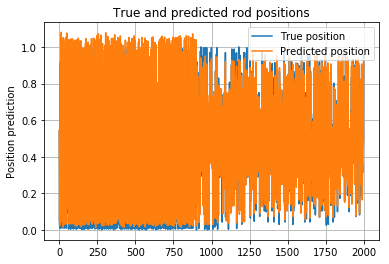

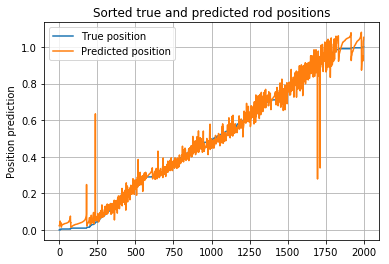

Wrote model to .\RodPosition\pos_cnn_weights_110.hdf
Epoch 112/112


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=112, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=111, workers=50, validation_steps=48)`


195/195 [==============================] - 504s - loss: 5.9225e-05 - me: 5.9225e-05 - mse: 7.1875e-06 - val_loss: 2.3380e-05 - val_me: 2.3380e-05 - val_mse: 1.0335e-06
Wrote model to .\RodPosition\pos_cnn_weights_111.hdf
Epoch 113/113


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=113, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=112, workers=50, validation_steps=48)`


195/195 [==============================] - 504s - loss: 5.8660e-05 - me: 5.8660e-05 - mse: 7.1174e-06 - val_loss: 2.8020e-05 - val_me: 2.8020e-05 - val_mse: 1.5033e-06
Wrote model to .\RodPosition\pos_cnn_weights_112.hdf
Epoch 114/114


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=114, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=113, workers=50, validation_steps=48)`


195/195 [==============================] - 503s - loss: 5.7282e-05 - me: 5.7282e-05 - mse: 6.8193e-06 - val_loss: 2.2480e-05 - val_me: 2.2480e-05 - val_mse: 1.0504e-06
Wrote model to .\RodPosition\pos_cnn_weights_113.hdf
Epoch 115/115


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=115, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=114, workers=50, validation_steps=48)`


195/195 [==============================] - 503s - loss: 5.5893e-05 - me: 5.5893e-05 - mse: 6.6036e-06 - val_loss: 1.9532e-05 - val_me: 1.9532e-05 - val_mse: 8.4621e-07
Wrote model to .\RodPosition\pos_cnn_weights_114.hdf
Epoch 116/116


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=116, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=115, workers=50, validation_steps=48)`


195/195 [==============================] - 504s - loss: 5.5872e-05 - me: 5.5872e-05 - mse: 6.4841e-06 - val_loss: 1.9798e-05 - val_me: 1.9798e-05 - val_mse: 9.8255e-07
Predicted.


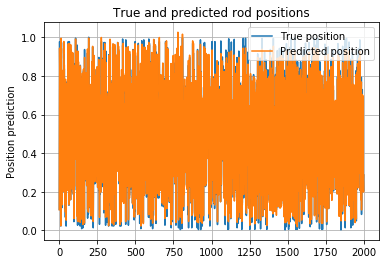

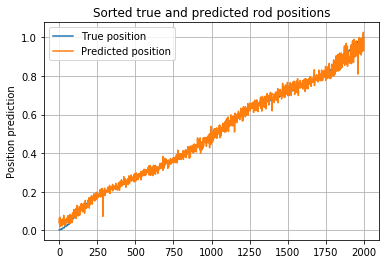

Wrote model to .\RodPosition\pos_cnn_weights_115.hdf
Epoch 117/117


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=117, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=116, workers=50, validation_steps=48)`


195/195 [==============================] - 503s - loss: 5.5171e-05 - me: 5.5171e-05 - mse: 6.3984e-06 - val_loss: 1.7100e-05 - val_me: 1.7100e-05 - val_mse: 6.6041e-07
Wrote model to .\RodPosition\pos_cnn_weights_116.hdf
Epoch 118/118


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=118, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=117, workers=50, validation_steps=48)`


195/195 [==============================] - 503s - loss: 5.4417e-05 - me: 5.4417e-05 - mse: 6.1669e-06 - val_loss: 1.7992e-05 - val_me: 1.7992e-05 - val_mse: 8.5446e-07
Wrote model to .\RodPosition\pos_cnn_weights_117.hdf
Epoch 119/119


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=119, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=118, workers=50, validation_steps=48)`


195/195 [==============================] - 504s - loss: 5.3480e-05 - me: 5.3480e-05 - mse: 6.0668e-06 - val_loss: 1.8647e-05 - val_me: 1.8647e-05 - val_mse: 8.8678e-07
Wrote model to .\RodPosition\pos_cnn_weights_118.hdf
Epoch 120/120


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=120, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=119, workers=50, validation_steps=48)`


195/195 [==============================] - 504s - loss: 5.3219e-05 - me: 5.3219e-05 - mse: 5.9629e-06 - val_loss: 2.6155e-05 - val_me: 2.6155e-05 - val_mse: 1.2971e-06
Wrote model to .\RodPosition\pos_cnn_weights_119.hdf
Starting at lr=0.000010
Batch size 200: 195 training batches, 48 validation batches


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=121, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=120, workers=50, validation_steps=48)`


Epoch 121/121
195/195 [==============================] - 504s - loss: 5.0107e-05 - me: 5.0107e-05 - mse: 5.4826e-06 - val_loss: 1.8619e-05 - val_me: 1.8619e-05 - val_mse: 7.5834e-07
Predicted.


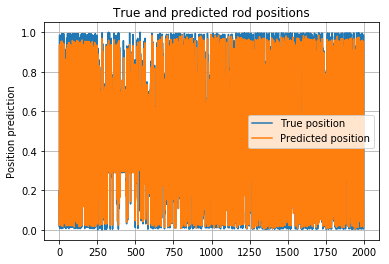

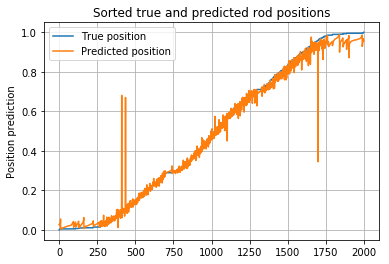

Wrote model to .\RodPosition\pos_cnn_weights_120.hdf
Epoch 122/122


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=122, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=121, workers=50, validation_steps=48)`


195/195 [==============================] - 505s - loss: 4.9994e-05 - me: 4.9994e-05 - mse: 5.3985e-06 - val_loss: 1.4726e-05 - val_me: 1.4726e-05 - val_mse: 7.0772e-07
Wrote model to .\RodPosition\pos_cnn_weights_121.hdf
Epoch 123/123


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=123, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=122, workers=50, validation_steps=48)`


195/195 [==============================] - 505s - loss: 5.0113e-05 - me: 5.0113e-05 - mse: 5.4374e-06 - val_loss: 1.5032e-05 - val_me: 1.5032e-05 - val_mse: 6.6852e-07
Wrote model to .\RodPosition\pos_cnn_weights_122.hdf
Epoch 124/124


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=124, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=123, workers=50, validation_steps=48)`


195/195 [==============================] - 504s - loss: 4.9558e-05 - me: 4.9558e-05 - mse: 5.4064e-06 - val_loss: 1.5115e-05 - val_me: 1.5115e-05 - val_mse: 5.6087e-07
Wrote model to .\RodPosition\pos_cnn_weights_123.hdf
Epoch 125/125


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=125, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=124, workers=50, validation_steps=48)`


195/195 [==============================] - 505s - loss: 4.9648e-05 - me: 4.9648e-05 - mse: 5.4482e-06 - val_loss: 1.6478e-05 - val_me: 1.6478e-05 - val_mse: 6.6058e-07
Wrote model to .\RodPosition\pos_cnn_weights_124.hdf
Epoch 126/126


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=126, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=125, workers=50, validation_steps=48)`


195/195 [==============================] - 506s - loss: 4.9562e-05 - me: 4.9562e-05 - mse: 5.3714e-06 - val_loss: 1.4515e-05 - val_me: 1.4515e-05 - val_mse: 5.1942e-07
Predicted.


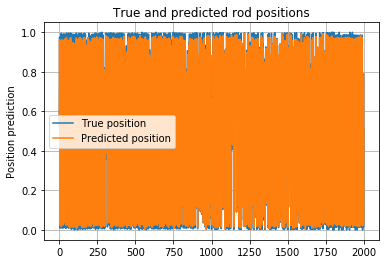

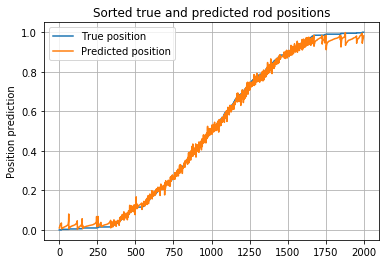

Wrote model to .\RodPosition\pos_cnn_weights_125.hdf
Epoch 127/127


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=127, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=126, workers=50, validation_steps=48)`


195/195 [==============================] - 504s - loss: 4.9795e-05 - me: 4.9795e-05 - mse: 5.5047e-06 - val_loss: 1.2974e-05 - val_me: 1.2974e-05 - val_mse: 4.5830e-07
Wrote model to .\RodPosition\pos_cnn_weights_126.hdf
Epoch 128/128


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=128, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=127, workers=50, validation_steps=48)`


195/195 [==============================] - 505s - loss: 4.9301e-05 - me: 4.9301e-05 - mse: 5.3646e-06 - val_loss: 1.8471e-05 - val_me: 1.8471e-05 - val_mse: 8.1429e-07
Wrote model to .\RodPosition\pos_cnn_weights_127.hdf
Epoch 129/129


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=129, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=128, workers=50, validation_steps=48)`


195/195 [==============================] - 505s - loss: 4.8818e-05 - me: 4.8818e-05 - mse: 5.2502e-06 - val_loss: 1.7007e-05 - val_me: 1.7007e-05 - val_mse: 6.9146e-07
Wrote model to .\RodPosition\pos_cnn_weights_128.hdf
Epoch 130/130


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=130, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=129, workers=50, validation_steps=48)`


195/195 [==============================] - 506s - loss: 4.9202e-05 - me: 4.9202e-05 - mse: 5.2761e-06 - val_loss: 1.4993e-05 - val_me: 1.4993e-05 - val_mse: 5.7689e-07
Wrote model to .\RodPosition\pos_cnn_weights_129.hdf
Epoch 131/131


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=131, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=130, workers=50, validation_steps=48)`


195/195 [==============================] - 504s - loss: 4.9223e-05 - me: 4.9223e-05 - mse: 5.3078e-06 - val_loss: 1.4618e-05 - val_me: 1.4618e-05 - val_mse: 5.3449e-07
Predicted.


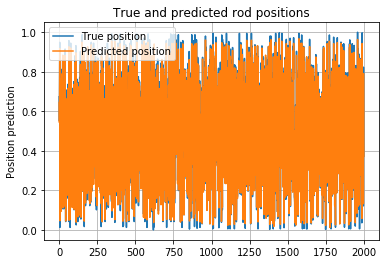

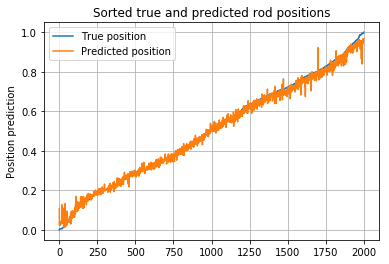

Wrote model to .\RodPosition\pos_cnn_weights_130.hdf
Epoch 132/132


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=132, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=131, workers=50, validation_steps=48)`


195/195 [==============================] - 505s - loss: 4.9183e-05 - me: 4.9183e-05 - mse: 5.3750e-06 - val_loss: 1.5292e-05 - val_me: 1.5292e-05 - val_mse: 7.2084e-07
Wrote model to .\RodPosition\pos_cnn_weights_131.hdf
Epoch 133/133


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=133, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=132, workers=50, validation_steps=48)`


195/195 [==============================] - 505s - loss: 4.8558e-05 - me: 4.8558e-05 - mse: 5.1212e-06 - val_loss: 1.4378e-05 - val_me: 1.4378e-05 - val_mse: 5.5926e-07
Wrote model to .\RodPosition\pos_cnn_weights_132.hdf
Epoch 134/134


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=134, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=133, workers=50, validation_steps=48)`


195/195 [==============================] - 505s - loss: 4.8788e-05 - me: 4.8788e-05 - mse: 5.2468e-06 - val_loss: 1.4725e-05 - val_me: 1.4725e-05 - val_mse: 5.5201e-07
Wrote model to .\RodPosition\pos_cnn_weights_133.hdf


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=135, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=134, workers=50, validation_steps=48)`


Epoch 135/135
195/195 [==============================] - 508s - loss: 4.8749e-05 - me: 4.8749e-05 - mse: 5.2298e-06 - val_loss: 1.3036e-05 - val_me: 1.3036e-05 - val_mse: 4.7364e-07
Wrote model to .\RodPosition\pos_cnn_weights_134.hdf
Starting at lr=0.000001
Batch size 200: 195 training batches, 48 validation batches


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=136, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=135, workers=50, validation_steps=48)`


Epoch 136/136
195/195 [==============================] - 509s - loss: 4.8719e-05 - me: 4.8719e-05 - mse: 5.2014e-06 - val_loss: 1.5040e-05 - val_me: 1.5040e-05 - val_mse: 5.5454e-07
Predicted.


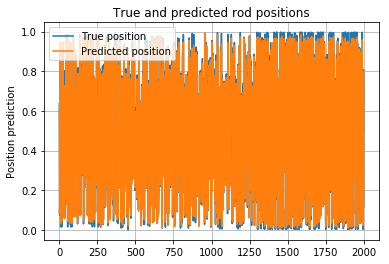

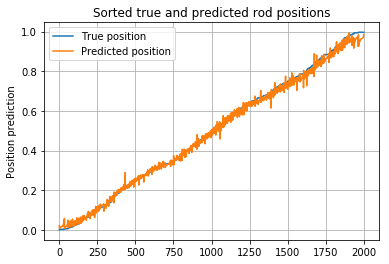

Wrote model to .\RodPosition\pos_cnn_weights_135.hdf
Epoch 137/137


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=137, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=136, workers=50, validation_steps=48)`


195/195 [==============================] - 507s - loss: 4.8228e-05 - me: 4.8228e-05 - mse: 5.0465e-06 - val_loss: 1.4274e-05 - val_me: 1.4274e-05 - val_mse: 5.1852e-07
Wrote model to .\RodPosition\pos_cnn_weights_136.hdf
Epoch 138/138


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=138, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=137, workers=50, validation_steps=48)`


195/195 [==============================] - 510s - loss: 4.8473e-05 - me: 4.8473e-05 - mse: 5.1773e-06 - val_loss: 1.4249e-05 - val_me: 1.4249e-05 - val_mse: 6.8264e-07
Wrote model to .\RodPosition\pos_cnn_weights_137.hdf
Epoch 139/139


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=139, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=138, workers=50, validation_steps=48)`


 89/195 [============>.................] - ETA: 216s - loss: 4.8804e-05 - me: 4.8804e-05 - mse: 5.2477e-06
User stopped the training.


In [12]:
batch_size = 200

(epoch, stop) = run_train(model, batch_size, training, lr=0.0001,start_epoch=epoch, num_epochs=15, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=5)
if not stop:
    (epoch, stop) = run_train(model, batch_size, training, lr=0.00001,start_epoch=epoch, num_epochs=15, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=5)
if not stop:
    (epoch, stop) = run_train(model, batch_size, training, lr=0.000001,start_epoch=epoch, num_epochs=15, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=5)
if not stop:
    (epoch, stop) = run_train(model, batch_size, training, lr=0.0000001,start_epoch=epoch, num_epochs=15, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=5)


Starting at lr=0.000010
Batch size 200: 195 training batches, 48 validation batches


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=140, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=139, workers=50, validation_steps=48)`


Epoch 140/140
195/195 [==============================] - 515s - loss: 3.6934e-05 - me: 3.6934e-05 - mse: 3.3330e-06 - val_loss: 1.8418e-05 - val_me: 1.8418e-05 - val_mse: 8.7982e-07
Wrote model to .\RodPosition\pos_cnn_weights_139.hdf
Epoch 141/141


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=141, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=140, workers=50, validation_steps=48)`


195/195 [==============================] - 508s - loss: 3.5485e-05 - me: 3.5485e-05 - mse: 3.0593e-06 - val_loss: 1.8090e-05 - val_me: 1.8090e-05 - val_mse: 8.3280e-07
Predicted.


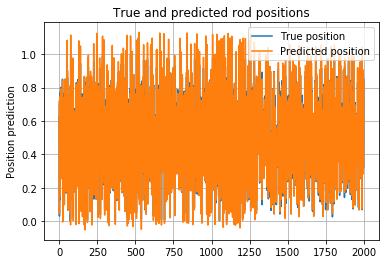

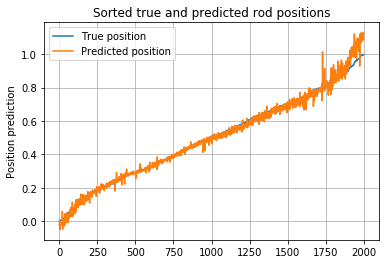

Wrote model to .\RodPosition\pos_cnn_weights_140.hdf
Epoch 142/142


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=142, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=141, workers=50, validation_steps=48)`


195/195 [==============================] - 503s - loss: 3.5236e-05 - me: 3.5236e-05 - mse: 3.0109e-06 - val_loss: 1.8778e-05 - val_me: 1.8778e-05 - val_mse: 9.0133e-07
Wrote model to .\RodPosition\pos_cnn_weights_141.hdf
Epoch 143/143


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=143, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=142, workers=50, validation_steps=48)`


195/195 [==============================] - 502s - loss: 3.4938e-05 - me: 3.4938e-05 - mse: 2.9637e-06 - val_loss: 1.8054e-05 - val_me: 1.8054e-05 - val_mse: 9.3210e-07
Wrote model to .\RodPosition\pos_cnn_weights_142.hdf
Epoch 144/144


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=144, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=143, workers=50, validation_steps=48)`


195/195 [==============================] - 504s - loss: 3.4793e-05 - me: 3.4793e-05 - mse: 2.9112e-06 - val_loss: 1.8750e-05 - val_me: 1.8750e-05 - val_mse: 8.9588e-07
Wrote model to .\RodPosition\pos_cnn_weights_143.hdf
Epoch 145/145


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, class_weight=None, callbacks=None, epochs=145, max_queue_size=50, verbose=1, validation_data=<__main__...., initial_epoch=144, workers=50, validation_steps=48)`


142/195 [====================>.........] - ETA: 105s - loss: 3.4863e-05 - me: 3.4863e-05 - mse: 2.8799e-06
User stopped the training.


In [15]:
batch_size = 200

(epoch, stop) = run_train(model, batch_size, training, lr=0.00001,start_epoch=epoch, num_epochs=15, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=5)
if not stop:
    (epoch, stop) = run_train(model, batch_size, training, lr=0.000001,start_epoch=epoch, num_epochs=15, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=5)
if not stop:
    (epoch, stop) = run_train(model, batch_size, training, lr=0.0000001,start_epoch=epoch, num_epochs=15, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=5)
if not stop:
    (epoch, stop) = run_train(model, batch_size, training, lr=0.00000001,start_epoch=epoch, num_epochs=15, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=5)


Loaded model.
Starting at lr=0.000010
Batch size 200: 195 training batches, 48 validation batches


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, workers=50, callbacks=None, max_queue_size=50, epochs=144, initial_epoch=143, validation_data=<__main__...., class_weight=None, validation_steps=48, verbose=1)`


Epoch 144/144
195/195 [==============================] - 532s - loss: 5.4686e-05 - me: 5.4686e-05 - mse: 8.0740e-06 - val_loss: 3.5394e-05 - val_me: 3.5394e-05 - val_mse: 3.6498e-06
Wrote model to .\RodPosition\pos_cnn_weights_143.hdf
Epoch 145/145


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, workers=50, callbacks=None, max_queue_size=50, epochs=145, initial_epoch=144, validation_data=<__main__...., class_weight=None, validation_steps=48, verbose=1)`


195/195 [==============================] - 519s - loss: 4.4368e-05 - me: 4.4368e-05 - mse: 4.5858e-06 - val_loss: 2.8603e-05 - val_me: 2.8603e-05 - val_mse: 2.0898e-06
Wrote model to .\RodPosition\pos_cnn_weights_144.hdf


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, workers=50, callbacks=None, max_queue_size=50, epochs=146, initial_epoch=145, validation_data=<__main__...., class_weight=None, validation_steps=48, verbose=1)`


Epoch 146/146
195/195 [==============================] - 519s - loss: 4.1837e-05 - me: 4.1837e-05 - mse: 3.8715e-06 - val_loss: 2.6585e-05 - val_me: 2.6585e-05 - val_mse: 1.8271e-06
Predicted.


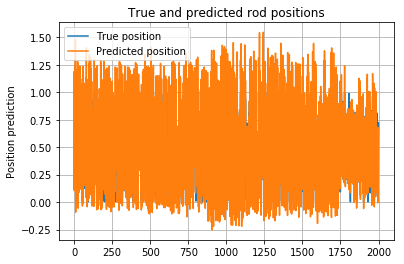

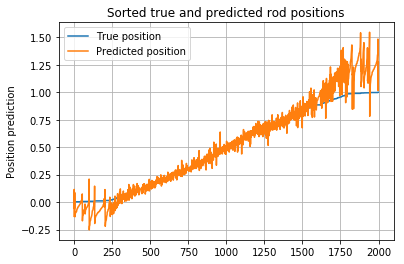

Wrote model to .\RodPosition\pos_cnn_weights_145.hdf
Epoch 147/147


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, workers=50, callbacks=None, max_queue_size=50, epochs=147, initial_epoch=146, validation_data=<__main__...., class_weight=None, validation_steps=48, verbose=1)`


195/195 [==============================] - 519s - loss: 4.0377e-05 - me: 4.0377e-05 - mse: 3.5686e-06 - val_loss: 2.5677e-05 - val_me: 2.5677e-05 - val_mse: 1.6583e-06
Wrote model to .\RodPosition\pos_cnn_weights_146.hdf
Epoch 148/148

C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, workers=50, callbacks=None, max_queue_size=50, epochs=148, initial_epoch=147, validation_data=<__main__...., class_weight=None, validation_steps=48, verbose=1)`



195/195 [==============================] - 520s - loss: 3.9908e-05 - me: 3.9908e-05 - mse: 3.5755e-06 - val_loss: 2.4814e-05 - val_me: 2.4814e-05 - val_mse: 1.5476e-06
Wrote model to .\RodPosition\pos_cnn_weights_147.hdf


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, workers=50, callbacks=None, max_queue_size=50, epochs=149, initial_epoch=148, validation_data=<__main__...., class_weight=None, validation_steps=48, verbose=1)`


Epoch 149/149
195/195 [==============================] - 519s - loss: 3.9026e-05 - me: 3.9026e-05 - mse: 3.3866e-06 - val_loss: 2.4329e-05 - val_me: 2.4329e-05 - val_mse: 1.5413e-06
Wrote model to .\RodPosition\pos_cnn_weights_148.hdf
Epoch 150/150

C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, workers=50, callbacks=None, max_queue_size=50, epochs=150, initial_epoch=149, validation_data=<__main__...., class_weight=None, validation_steps=48, verbose=1)`



195/195 [==============================] - 520s - loss: 3.8565e-05 - me: 3.8565e-05 - mse: 3.3754e-06 - val_loss: 2.2884e-05 - val_me: 2.2884e-05 - val_mse: 1.5607e-06
Wrote model to .\RodPosition\pos_cnn_weights_149.hdf


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, workers=50, callbacks=None, max_queue_size=50, epochs=151, initial_epoch=150, validation_data=<__main__...., class_weight=None, validation_steps=48, verbose=1)`


Epoch 151/151
 44/195 [=====>........................] - ETA: 302s - loss: 3.9172e-05 - me: 3.9172e-05 - mse: 3.5364e-06

In [ ]:
# Load the best model result
epoch = 143
model.load_weights(WEIGHTS_FNAME % epoch, by_name=True)
print("Loaded model.")


batch_size = 200

(epoch, stop) = run_train(model, batch_size, training, lr=0.00001,start_epoch=epoch, num_epochs=15, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=5)
if not stop:
    (epoch, stop) = run_train(model, batch_size, training, lr=0.000001,start_epoch=epoch, num_epochs=15, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=5)
if not stop:
    (epoch, stop) = run_train(model, batch_size, training, lr=0.0000001,start_epoch=epoch, num_epochs=15, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=5)
if not stop:
    (epoch, stop) = run_train(model, batch_size, training, lr=0.00000001,start_epoch=epoch, num_epochs=15, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=5)


In [ ]:
# Load the best model result
epoch = 149
model.load_weights(WEIGHTS_FNAME % epoch, by_name=True)
print("Loaded model.")


batch_size = 200

(epoch, stop) = run_train(model, batch_size, training, lr=0.00001,start_epoch=epoch, num_epochs=15, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=5)
if not stop:
    (epoch, stop) = run_train(model, batch_size, training, lr=0.000001,start_epoch=epoch, num_epochs=15, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=5)
if not stop:
    (epoch, stop) = run_train(model, batch_size, training, lr=0.0000001,start_epoch=epoch, num_epochs=15, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=5)
if not stop:
    (epoch, stop) = run_train(model, batch_size, training, lr=0.00000001,start_epoch=epoch, num_epochs=15, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=5)


Loaded model.
Starting at lr=0.000010
Batch size 200: 195 training batches, 48 validation batches


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:231: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., 195, max_queue_size=50, validation_data=<__main__...., epochs=150, class_weight=None, callbacks=None, validation_steps=48, initial_epoch=149, verbose=1, workers=50)`


Epoch 150/150
 88/195 [============>.................] - ETA: 214s - loss: 4.6790e-05 - me: 4.6790e-05 - mse: 5.4713e-06